<div align='center'><b><font size=4.5>Прогнозирование удовлетворённости и удержания сотрудников компании <font color='#2694DE'>«Работа с заботой»</font></font></b></div>
<hr>

<p style='text-align: justify;'>Целью данной работы является оптимизация управления персоналом компании <b>«Работа с заботой»</b> с помощью машинного обучения для предсказания уровня удовлетворённости сотрудников и вероятности их увольнения. Проект позволит компании более эффективно управлять своим персоналом, снизить риски, связанные с оттоком сотрудников, и создать более благоприятную рабочую среду, что в конечном итоге приведёт к увеличению производительности и устойчивости бизнеса.</p>

<hr>
<div align='center'><font size=4.5><b>Задача 1: предсказание уровня удовлетворённости сотрудника</b></font></div>
<div align='left'><b>Описание данных</b></div>

<ul> 
<li><b>id</b> — уникальный идентификатор сотрудника;</li>
<li><b>dept</b> — отдел, в котором работает сотрудник;</li>
<li><b>level</b> — уровень занимаемой должности;</li>
<li><b>workload</b> — уровень загруженности сотрудника;</li>
<li><b>employment_years</b> — длительность работы в компании (в годах);</li>
<li><b>last_year_promo</b> — показывает, было ли повышение за последний год;</li>
<li><b>last_year_violations</b> — показывает, нарушал ли сотрудник трудовой договор за последний год;</li>
<li><b>supervisor_evaluation</b> — оценка качества работы сотрудника, которую дал руководитель;</li>
<li><b>salary</b> — ежемесячная зарплата сотрудника;</li>
<li><b>job_satisfaction_rate</b> — уровень удовлетворённости сотрудника работой в компании, целевой признак.</li>
</ul>

<br><br>

<div align='left'><b>План работы</b></div>

1. [Загрузка данных](#download)
   1. Загрузка файла train_job_satisfaction_rate.csv;
   2. Загрузка файла test_features.csv;
   3. Загрузка файла test_target_job_satisfaction_rate.csv;
2. [Предобработка данных](#treatment):
3. [Исследовательский анализ данных](#analysis)
4. [Корреляционный анализ](#corr_analysis):
5. [Подготовка данных](#section_5)
6. [Обучение моделей](#section_6)
7. [Промежуточные выводы](#conclusion)

<hr>
<div align='center'><font size=4.5><b>Задача 2: предсказание увольнения сотрудника из компании</b></font></div>
<div align='left'><b>Описание данных</b></div>

<ul> 
Входные признаки те же, что и для 1 задачи.
<li><b>quit</b> — увольнение сотрудника из компании, целевой признак.</li>
</ul>

<br><br>

<div align='left'><b>План работы</b></div>

1. [Загрузка данных](#download2)
   1. Загрузка файла train_quit.csv;
   2. Загрузка файла test_features.csv;
   3. Загрузка файла test_target_quit.csv;
2. [Предобработка данных](#treatment2):
3. [Исследовательский анализ данных](#analysis2)
4. [Добавление нового входного признака](#adding2)
5. [Корреляционный анализ](#corr_analysis2):
6. [Подготовка данных](#section_52)
7. [Обучение моделей](#section_62)
8. [Промежуточные выводы](#conclusion2)
9. [Итоговый вывод](#conclusionfinal)

<div align='center'><font size=4.5><b>Предсказание уровня удовлетворённости сотрудника</b></font></div>

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
libs = ['phik', 'shap']

for lib in libs:
    try:
        __import__(lib)
    except ModuleNotFoundError:
        !pip install {lib} -q
        __import__(lib)

In [3]:
import pandas as pd
import numpy as np
import math
import re
import csv
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import logging
import contextlib
import sys

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, recall_score, make_scorer, precision_score, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC

 <a id='download'></a>

## Загрузка данных

In [4]:
def csv_download(file_name: str) -> pd.DataFrame:
    '''Accepts the name of the file(the file name is specified with the extension, 
    if the file does not lie in the folder with this notebook, 
    the full path should be specified). 
    Selects the delimiter and decimal separator for correct data reading.
    Returns the DataFrame object obtained from the file with the passed name.'''
    
    sniffer = csv.Sniffer()
    with open(file_name) as file:
        sample = file.read(5000)
        delimiter = sniffer.sniff(sample).delimiter
        
        file.seek(0)
        reader = csv.reader(file, delimiter=delimiter)
        decimal_counts = {'.': 0, ',': 0}
        for row in reader:
            for cell in row:
                if re.match(r'^\d+,\d+$', cell):
                    decimal_counts[','] += 1
                elif re.match(r'^\d+\.\d+$', cell):
                    decimal_counts['.'] += 1
        decimal_separator = max(decimal_counts, key=decimal_counts.get)
        
        file.seek(0)
        data = pd.read_csv(file, decimal=decimal_separator, delimiter=delimiter)
        
    return data

In [5]:
def batch_opening(file_names: list[str]) -> tuple[pd.DataFrame]:
    '''Accepts a list with file names 
    (the file name is specified with the extension, 
    if the file does not lie in the folder with this notebook, 
    the full path should be specified). 
    Returns a tuple of DataFrame objects, 
    the number of which is equal to the number of file names.'''
    
    results = []
    for file_name in file_names:
        results.append(csv_download(file_name))
    return results

In [6]:
file_names=['/datasets/train_job_satisfaction_rate.csv', 
            '/datasets/test_features.csv', 
            '/datasets/test_target_job_satisfaction_rate.csv']
train_job_satisfaction_rate, test_features, test_target_job_satisfaction_rate = batch_opening(file_names)

In [7]:
frames = {'train_job_satisfaction_rate':train_job_satisfaction_rate, 
          'test_features':test_features, 
          'test_target_job_satisfaction_rate':test_target_job_satisfaction_rate}
for i, data in enumerate(frames.values(), 0):
    print()
    print(("\033[92mДАННЫЕ ИЗ ФАЙЛА \033[1m" + re.findall(r'/(\w+\.\w+)', file_names[i])[0]).center(140))
    display(data.head())
    display(data.info())


                                          ДАННЫЕ ИЗ ФАЙЛА train_job_satisfaction_rate.csv                                          


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None


                                                 ДАННЫЕ ИЗ ФАЙЛА test_features.csv                                                 


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None


                                       ДАННЫЕ ИЗ ФАЙЛА test_target_job_satisfaction_rate.csv                                       


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

В данном разделе были загружены данные из 3-х файлов в формате <i>.csv</i>. Данные в файлах соответствуют описанию. Полученные фреймы:

 - <b>train_job_satisfaction_rate</b> содержит 4000 строк и 10 столбцов. Пропущенны 6 занчений в столбце <i>dept</i> и 4 значения в столбце <i>level</i>. Типы данных: <i><font color='purple'>float</font></i>, <i><font color='purple'>int</font></i> и <i><font color='purple'>str</font></i>.
 - <b>test_features</b> содержит 2000 строк и 9 столбцов. Пропущенны 2 занчения в столбце <i>dept</i> и 1 значение в столбце <i>level</i>. Типы данных: <i><font color='purple'>int</font></i> и <i><font color='purple'>str</font></i>.
 - <b>test_target_job_satisfaction_rate</b> содержит 2000 строк и 2 столбца. Пропущенных значений в фрейме нет. Типы данных: <i><font color='purple'>float</font></i> и <i><font color='purple'>int</font></i>.
 

<hr>

 <a id='treatment'></a>

##  Предобработка данных

In [8]:
def show_unique_values(frames: list[pd.DataFrame], 
                       column_names: list[str], 
                       just_all_unique: bool=True) -> None:
    '''Display unique values from specified columns in given DataFrames.
    Does not return any value. It prints the results directly'''
    
    res = {}
    print()
    if not just_all_unique:
        for key, frame in frames.items():
            print(f'\033[92mУникальные значения в фрейме \033[1m{key}\033[0m\033[92m для столбца:\033[0m'.center(140))
            print('_'*120)
            for name in column_names:
                if name not in frame.columns:
                    continue
                res[name] = res.setdefault(name, set())
                res[name].update(str(i) for i in frame[name].unique())
                print(f'\033[1m{name}\033[0m', sorted([str(i) for i in frame[name].unique()]), sep='\n', end='\n\n')
            print('_'*120, end='\n\n\n')
    else:
        for key, frame in frames.items():
            for name in column_names:
                if name not in frame.columns:
                    continue
                res[name] = res.setdefault(name, set())
                res[name].update(str(i) for i in frame[name].unique())
            
    print(f'\033[92mВсе уникальные значения из всех фреймов\033[0m'.center(140))
    for key, value in res.items():
        print(f'\033[1m{key}:\033[0m')
        print(*(s.rjust(len(s) + 4) for s in sorted(value)), sep='\n', end='\n\n')


<hr>

Проверим наличие дубликатов. 

<hr>

In [9]:
frames = {'train_job_satisfaction_rate':train_job_satisfaction_rate, 
          'test_features':test_features, 
          'test_target_job_satisfaction_rate':test_target_job_satisfaction_rate}

for name, frame in frames.items():
    print(f"В фрейме {name} - {frame['id'].duplicated().sum()} дубликатов в столбце 'id'")

В фрейме train_job_satisfaction_rate - 0 дубликатов в столбце 'id'
В фрейме test_features - 0 дубликатов в столбце 'id'
В фрейме test_target_job_satisfaction_rate - 0 дубликатов в столбце 'id'


In [10]:
column_names = ['dept', 
                'level', 
                'workload', 
                'last_year_promo', 
                'last_year_violations']

frames = {'train_job_satisfaction_rate':train_job_satisfaction_rate, 
          'test_features':test_features}

show_unique_values(frames, column_names, just_all_unique=False)


                        Уникальные значения в фрейме train_job_satisfaction_rate для столбца:                         
________________________________________________________________________________________________________________________
dept
['hr', 'marketing', 'nan', 'purchasing', 'sales', 'technology']

level
['junior', 'middle', 'nan', 'sinior']

workload
['high', 'low', 'medium']

last_year_promo
['no', 'yes']

last_year_violations
['no', 'yes']

________________________________________________________________________________________________________________________


                               Уникальные значения в фрейме test_features для столбца:                                
________________________________________________________________________________________________________________________
dept
[' ', 'hr', 'marketing', 'nan', 'purchasing', 'sales', 'technology']

level
['junior', 'middle', 'nan', 'sinior']

workload
[' ', 'high', 'low', 'medium']

last_year_promo
[

<hr>

В фрейме <b>test_features </b> в столбцах <b>dept</b> и <b>workload</b> присутствуют пустые значения ' ', посмотрим на эти значения и сколько их от общего числа.

<hr>

In [11]:
empty_test_features = test_features.loc[(test_features['dept'] == ' ') | 
                                        (test_features['workload'] == ' '), :]
display(empty_test_features)
print(f"Процент значений ' ' составляют {round(empty_test_features.shape[0] / test_features.shape[0] * 100, 3)}%")

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


Процент значений ' ' составляют 0.1%


<hr>

Заменим значения ' ' на None и обработаем их в пайплайне.

<hr>

In [12]:
test_features.replace(' ', None, inplace=True);

In [13]:
frames = {'train_job_satisfaction_rate':train_job_satisfaction_rate, 
          'test_features':test_features}
show_unique_values(frames, column_names, just_all_unique=True)


                                              Все уникальные значения из всех фреймов                                              
dept:
    hr
    marketing
    nan
    purchasing
    sales
    technology

level:
    junior
    middle
    nan
    sinior

workload:
    high
    low
    medium

last_year_promo:
    no
    yes

last_year_violations:
    no
    yes



<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В результате предобработки данных было выполнено:</p>

 - Обнаружены пустые значения ' ' в <b>test_features</b>, которые составляли 0.1% всех данных;
 - Заменены значения ' ' в фрейме на None;

<hr>

 <a id='analysis'></a>

## Исследовательский анализ данных

In [14]:
def description(df: pd.DataFrame, column: str, ax: plt.Axes=None, 
               round_to: int = 3, cut_lim: bool = False, color_column: str = None,
               title: str = None, xlabel: str = None) -> None:
    '''Feature (column) description from DataFrame (df)'''
    
    if not ax:
        fig, ax = plt.subplots()
    if color_column:
        sns.boxplot(x=color_column, y=column, data=df, ax=ax)
    else:
        ax.boxplot(x=column, data=df)
        
    ax.grid()
    ax.set_title(title, 
                 weight='bold', 
                 size=15, 
                 color='darkred', 
                 pad=20)
    ax.set_xlabel(xlabel, 
                  weight='bold', 
                  size=12)
    stats = df[column].describe().round(round_to)
    legend_text = '\n'.join([f'{stat}: {value}' for stat, value in stats.items()])
    ax.legend([legend_text], loc='upper right', handlelength=0, fontsize=15)
    
    if cut_lim:
        q1 = np.quantile(df[column], 0.25)
        q3 = np.quantile(df[column], 0.75)
        iqr = q3 - q1
        ax.set_ylim((q1 - 1.6 * iqr, q3 + 1.6 * iqr))

In [15]:
def hist_plot(df: pd.DataFrame, column: str, 
              alpha: float=0.4, ax: plt.Axes=None, 
              bins: int = 10, color_column: str = None, order: bool=False, 
              xlabel: str = None, ylabel: str = None, title: str = None) -> None:
    '''Creating a histogram of a feature (column) from a DataFrame (df)'''
    
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    data = df.copy()
    if order:
        category_counts = data[column].value_counts()
        data[column] = pd.Categorical(data[column], categories=category_counts.index, ordered=True)
    
    if color_column:
        sns.histplot(data=data, 
                     x=column, 
                     hue=color_column, 
                     bins=bins, 
                     ax=ax, 
                     multiple='stack', 
                     alpha=alpha)
    else:
        df[column].plot(kind='hist', bins=bins, ax=ax)

    ax.grid()
    ax.set_xlabel(xlabel, 
                  weight='bold', 
                  size=12)
    ax.set_ylabel(ylabel, 
                  weight='bold', 
                  size=12)
    ax.set_title(title, 
                 weight='bold', 
                 size=15, 
                 color='darkred', 
                 pad=20)

In [16]:
def show_hists(df: pd.DataFrame, columns: list[str], color_column: str = None, 
               alpha: float=0.4, cat: bool=False, in_row: int=1,
               bins: int = 10, mask: dict[str]=dict()) -> None:
    '''Designed to display histograms and corresponding span charts 
    for a set of columns in the provided DataFrame.'''
    
    if not cat:
        fig, axes = plt.subplots(len(columns), 2, figsize=(16, len(columns) * 12))
    else:
        fig, axes = plt.subplots(math.ceil(len(columns) / in_row), in_row, 
                             figsize=(16, math.ceil(len(columns) / in_row) * 12))
        
    for i in range(len(columns)):
        xlabel = mask.setdefault(columns[i], ('X_label', 'Y_label', 'Title'))[0]
        ylabel = mask.setdefault(columns[i], ('X_label', 'Y_label', 'Title'))[1]
        title = mask.setdefault(columns[i], ('X_label', 'Y_label', 'Title'))[2]
        if not cat:
            if len(columns) == 1:
                ax_hist = axes[0]
                ax_desc = axes[1]
            else:
                ax_hist = axes[(i), 0]
                ax_desc = axes[(i), 1]
            hist_plot(df=df, 
                      column=columns[i], 
                      ax=ax_hist, 
                      color_column=color_column,
                      xlabel=xlabel, 
                      ylabel=ylabel, 
                      title=title, 
                      bins=bins, 
                      order=cat)
            description(df=df, 
                        column=columns[i], 
                        ax=ax_desc, 
                        title='Соответсвующая диаграмма размаха', 
                        xlabel=xlabel, 
                        cut_lim=True)
        else:
            if len(columns) == 1:
                ax = axes
            elif in_row == 1:
                ax = axes[i]
            else:
                ax = axes[(i) // in_row, (i) % in_row]
            hist_plot(df=df, 
                      column=columns[i], 
                      ax=ax, 
                      color_column=color_column,
                      xlabel=xlabel, 
                      ylabel=ylabel, 
                      title=title, 
                      bins=bins, 
                      order=cat)

<hr>

Рассмотрим распределения признаков в фреме <b>train_job_satisfaction_rate</b>.

<hr>

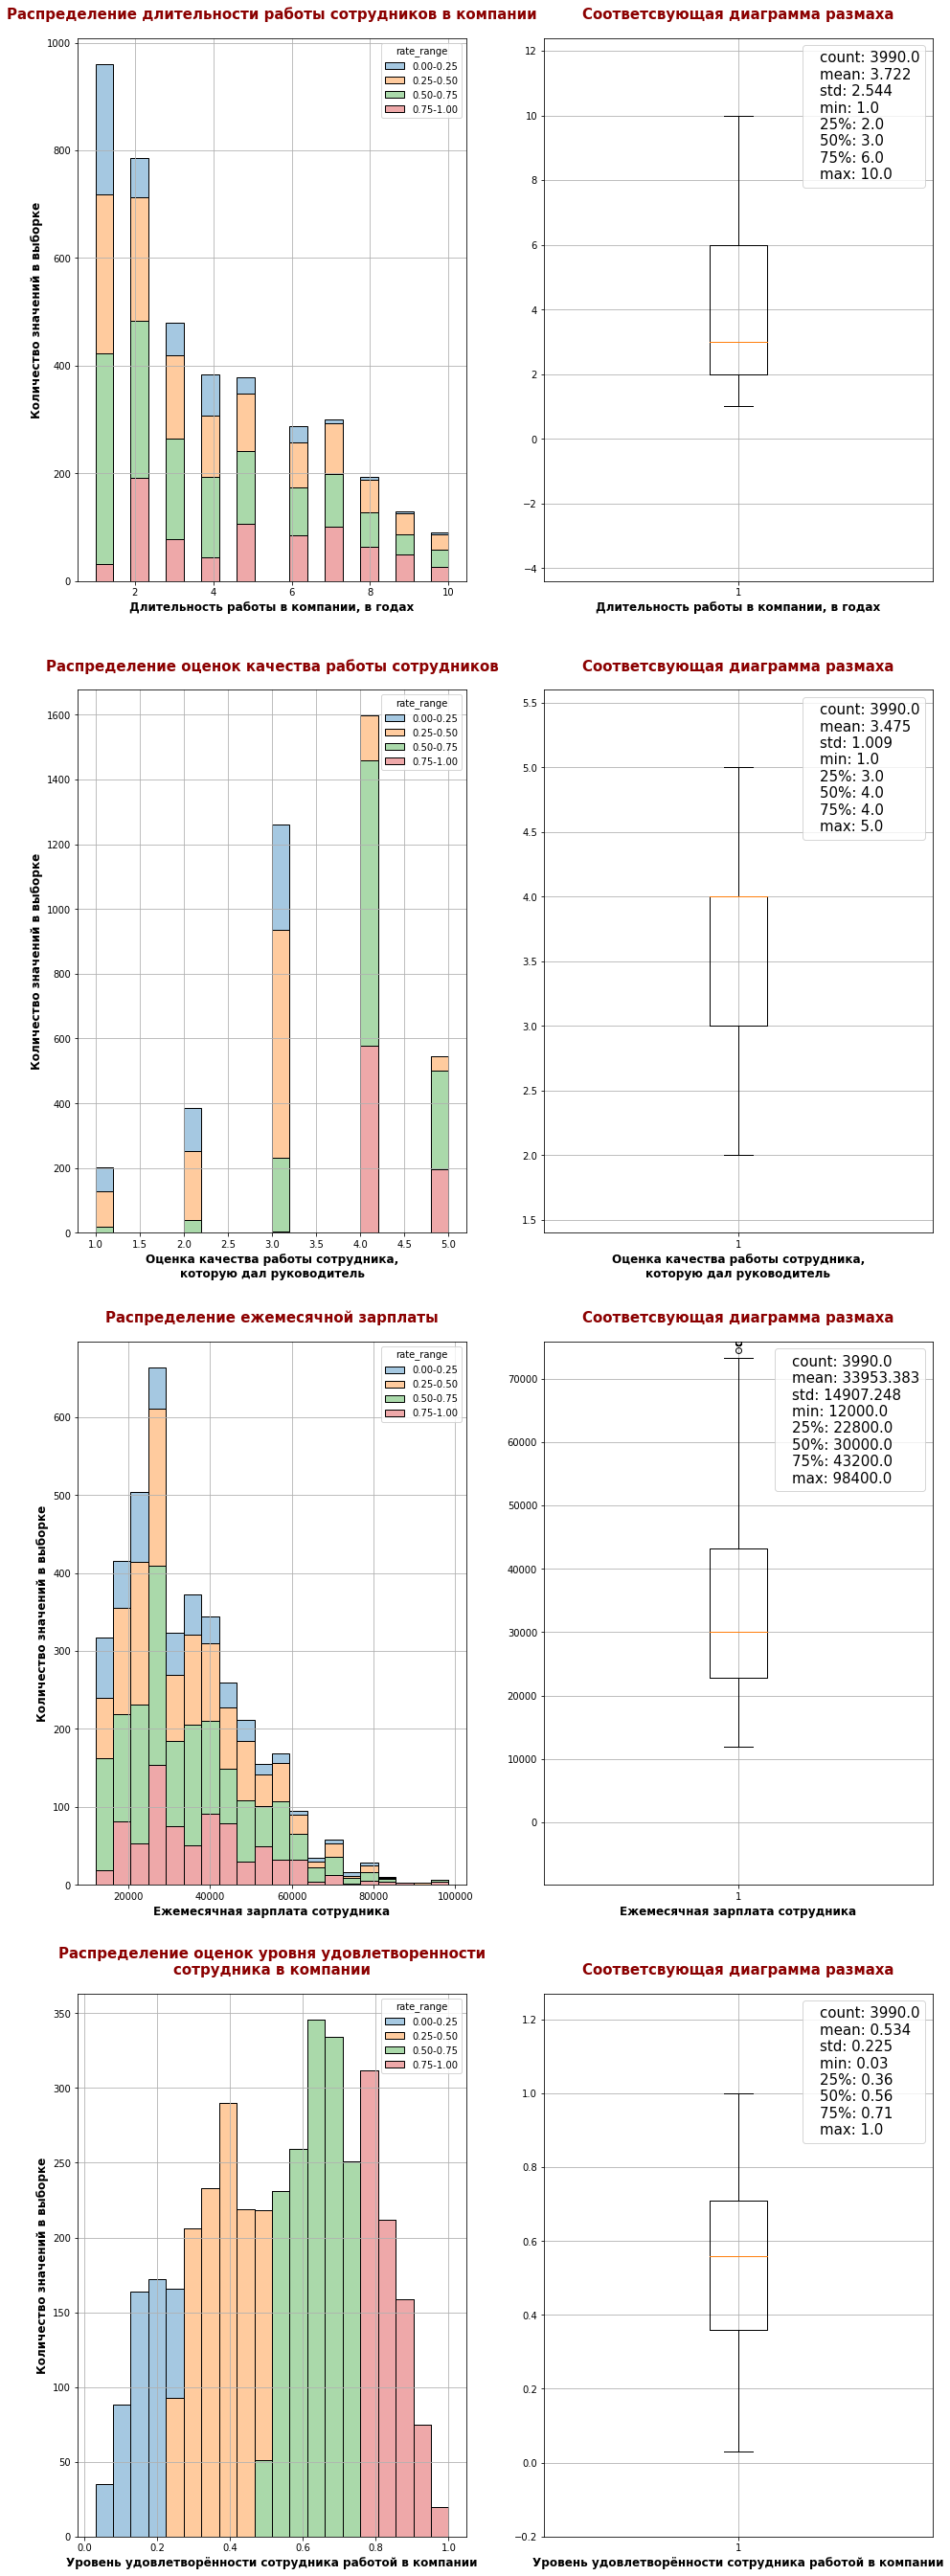

In [17]:
num_params = ['employment_years', 
              'supervisor_evaluation', 
              'salary', 
              'job_satisfaction_rate']

num_mask = {'employment_years':('Длительность работы в компании, в годах', 
                                'Количество значений в выборке', 
                                'Распределение длительности работы сотрудников в компании'), 
            'supervisor_evaluation':('Оценка качества работы сотрудника,\nкоторую дал руководитель', 
                                     'Количество значений в выборке', 
                                     'Распределение оценок качества работы сотрудников'), 
            'salary':('Ежемесячная зарплата сотрудника', 
                      'Количество значений в выборке', 
                      'Распределение ежемесячной зарплаты'), 
            'job_satisfaction_rate':('Уровень удовлетворённости сотрудника работой в компании', 
                                     'Количество значений в выборке', 
                                     'Распределение оценок уровня удовлетворенности\nсотрудника в компании')}


bins = [0, 0.25, 0.51, 0.76, 1.01]
labels = ['0.00-0.25', '0.25-0.50', '0.50-0.75', '0.75-1.00']
analize_train_job_satisfaction_rate = train_job_satisfaction_rate.dropna()
analize_train_job_satisfaction_rate['rate_range'] = pd.cut(train_job_satisfaction_rate['job_satisfaction_rate'], 
                                                           bins=bins, 
                                                           labels=labels, 
                                                           right=False, 
                                                           include_lowest=True)
show_hists(df=analize_train_job_satisfaction_rate,
           columns=num_params, 
           mask=num_mask, 
           bins=20, 
           color_column='rate_range', 
           alpha=0.3)


<hr>

<p style='text-align: justify;'>График распределение длительности работы сотрудников в компании имеет форму, похожую на экспоненциальное распределение.
<br>Чем дольше работает сотрудник, тем выше вероятность, что он поставит высокую оценку, сотрудники, работающие в компании год и меньше, вероятнее всего не поставят оценку выше 0.75.</p>

<p style='text-align: justify;'>Распределение оценок качества работы сотрудников похоже на нормальное распределение со смещением вправо, в сторону повышенной оценки.
<br>Обычно высокие оценки удовлетворенности - выше 0.5, ставят сотрудники, которых руководитель оценил на 4 и 5, такие сотрудники почти не ставят оценки меньше 0.25.</p>

<p style='text-align: justify;'>Зарплаты распределены нормально со смещением в лево, в сторону меньших значений. Есть небольшие выбросы со значениями от 70 до 100 тыс.
<br>По графику не прослеживается зависимость между зарплатой и тем, поставит сотрудник высокую, низкую или среднюю оценку.</p>

<p style='text-align: justify;'>Распределение оценок уровня удовлетворенности сотрудника в компании имеет нормальный вид.</p>

<hr>

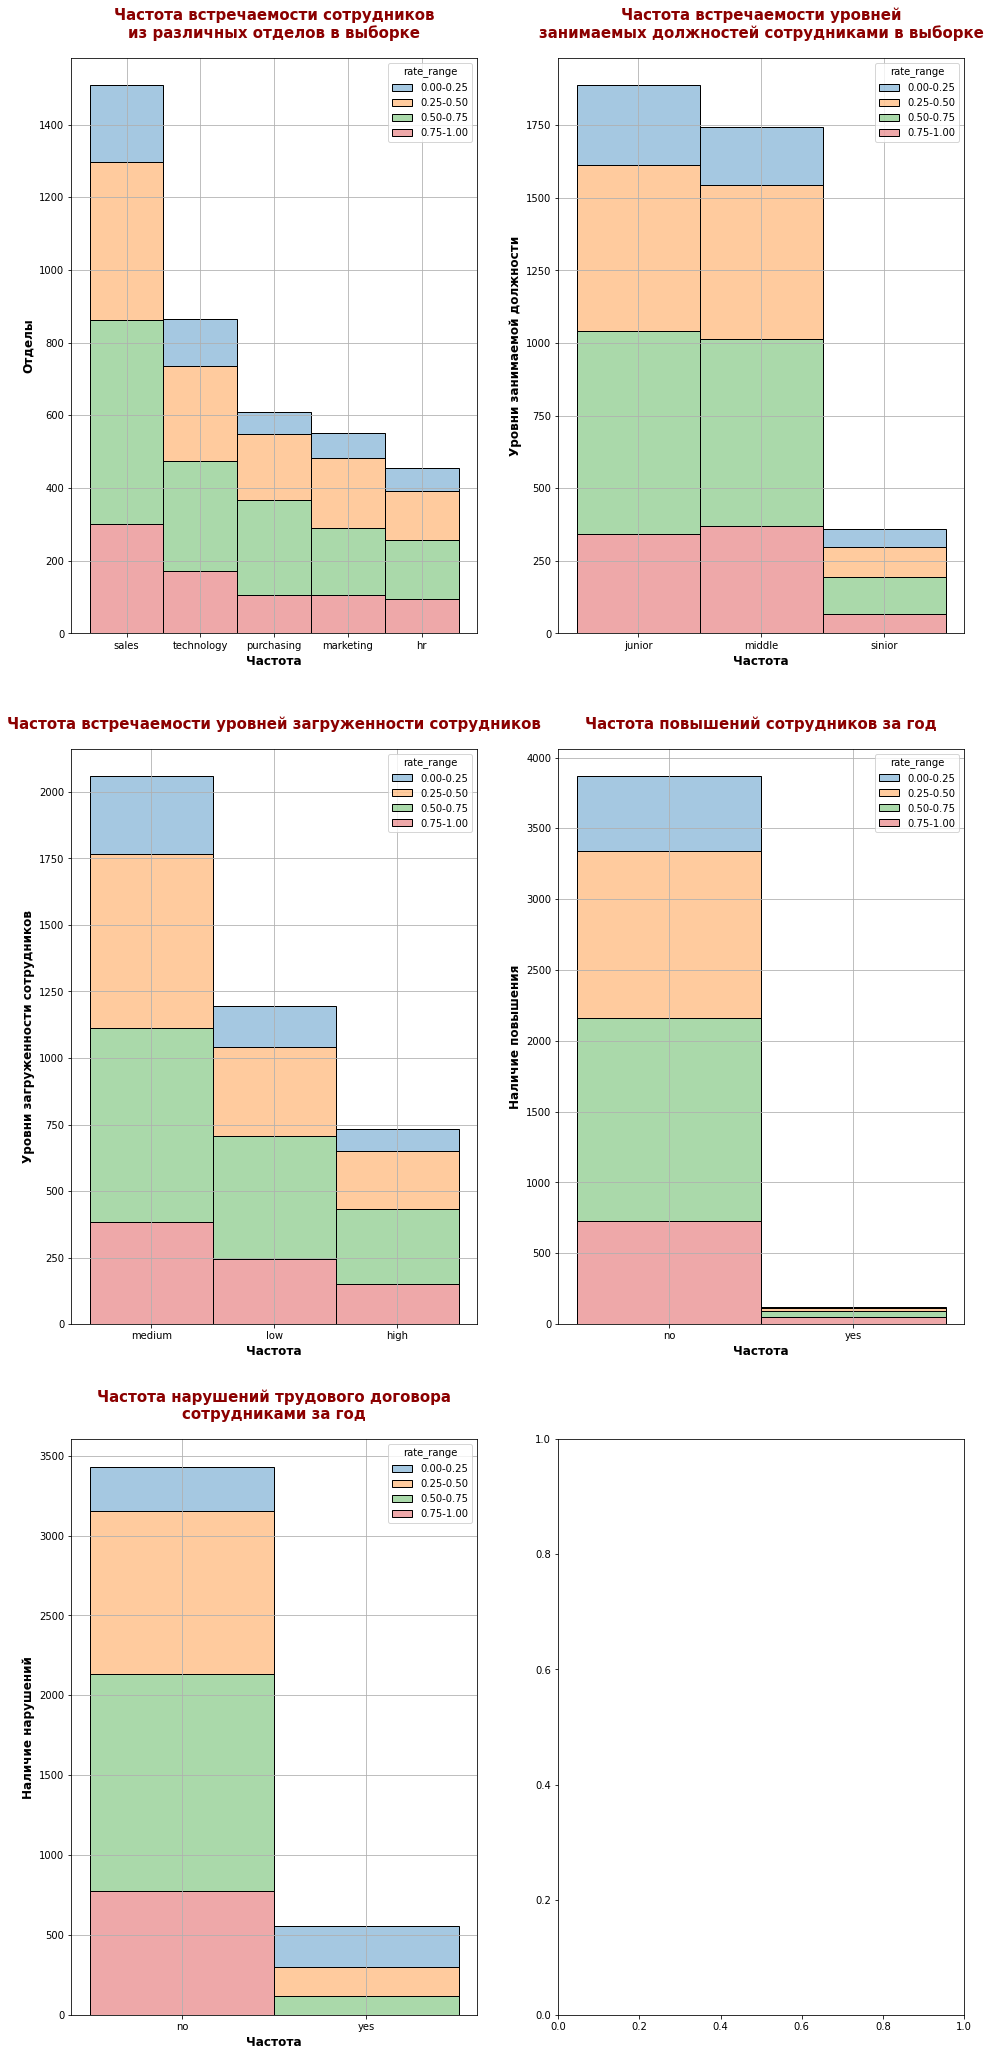

In [18]:
cat_params = ['dept', 
              'level', 
              'workload', 
              'last_year_promo', 
              'last_year_violations']

cat_mask = {'dept':('Частота', 
                    'Отделы', 
                    'Частота встречаемости сотрудников\nиз различных отделов в выборке'), 
            'level':('Частота', 
                     'Уровни занимаемой должности', 
                     'Частота встречаемости уровней\nзанимаемых должностей сотрудниками в выборке'), 
            'workload':('Частота', 
                        'Уровни загруженности сотрудников', 
                        'Частота встречаемости уровней загруженности сотрудников'), 
            'last_year_promo':('Частота', 
                               'Наличие повышения', 
                               'Частота повышений сотрудников за год'), 
            'last_year_violations':('Частота', 
                                    'Наличие нарушений', 
                                    'Частота нарушений трудового договора\nсотрудниками за год')}

show_hists(df=analize_train_job_satisfaction_rate,
           columns=cat_params, 
           mask=cat_mask, 
           color_column='rate_range', 
           alpha=0.3, 
           cat=True, 
           in_row=2)

<hr>

<p style='text-align: justify;'>В выборке очень мало сотрудников, получивших повышение за последний год. Сотрудники, которые получили повышение в течении последнего года, ставят в основном оценки выше 0.5.</p>

<p style='text-align: justify;'>Также очень немного сотрудников, нарушивших трудовой договор за последний год. Такие сотрудники в большинстве случаев ставят оценку ниже 0.5 и совсем не ставят оченки выше 0.75.</p>

<hr>

<hr>

<p style='text-align: justify;'>Построим аналогичные распределения для тестовых данных, для этого объединим во вспомогательном фрейме <b>test_features</b> и <b>test_target_job_satisfaction_rate</b>.</p>

<hr>

In [19]:
analize_test_job_satisfaction_rate = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')
analize_test_job_satisfaction_rate.shape

(2000, 10)

<a id='num_plots'></a>

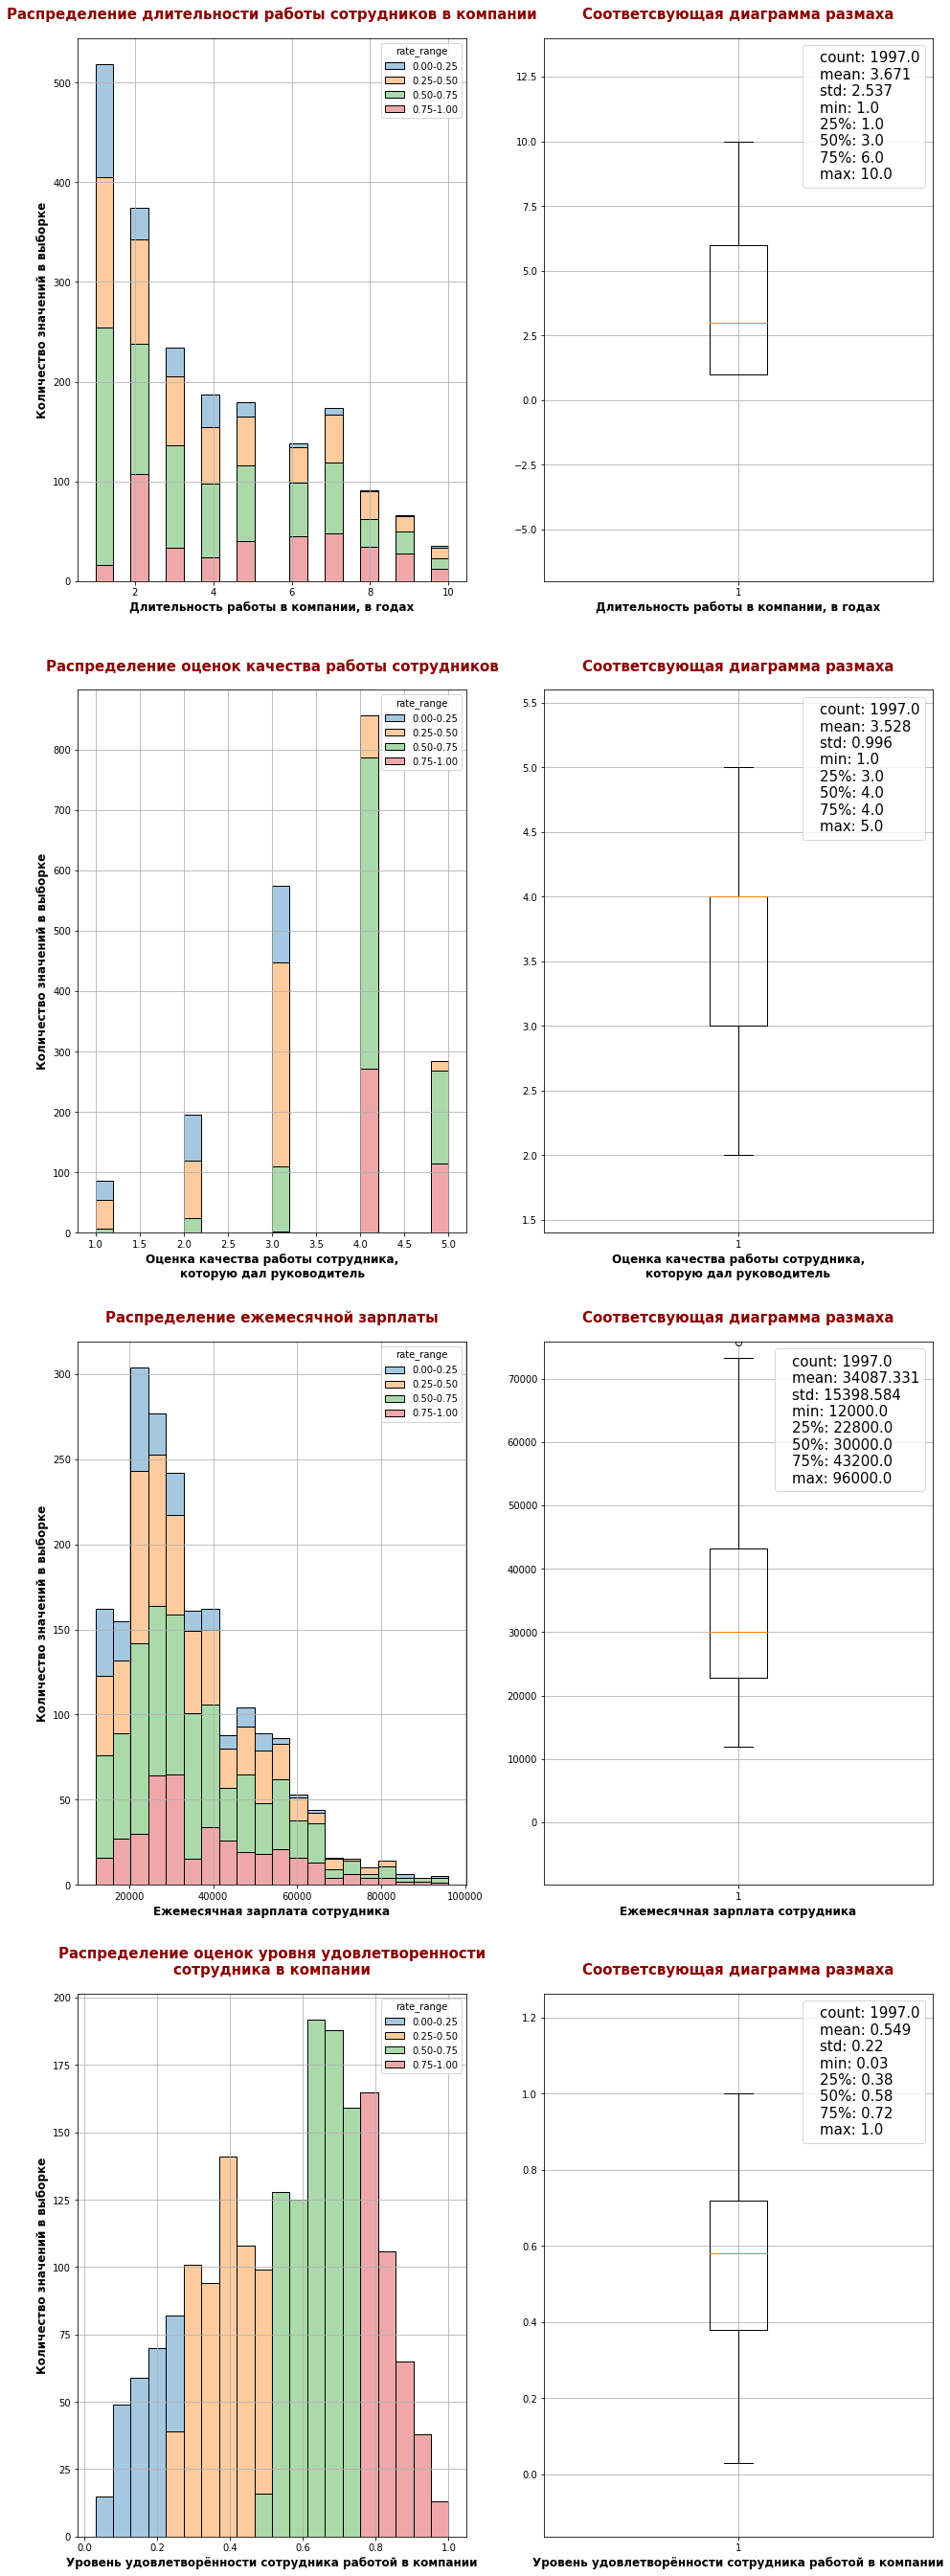

In [21]:
analize_test_job_satisfaction_rate['rate_range'] = pd.cut(analize_test_job_satisfaction_rate['job_satisfaction_rate'], 
                                                          bins=bins, 
                                                          labels=labels, 
                                                          right=False, 
                                                          include_lowest=True)
show_hists(df=analize_test_job_satisfaction_rate,
           columns=num_params, 
           mask=num_mask, 
           bins=20, 
           color_column='rate_range', 
           alpha=0.3)

<hr>
<a id='cat_plots'></a>
Распределения количественных параметров похожи на распределения из тренеровочной выборки. 

В тестовой выборке чаще встречаются зарплаты более 80 тысяч.

<hr>

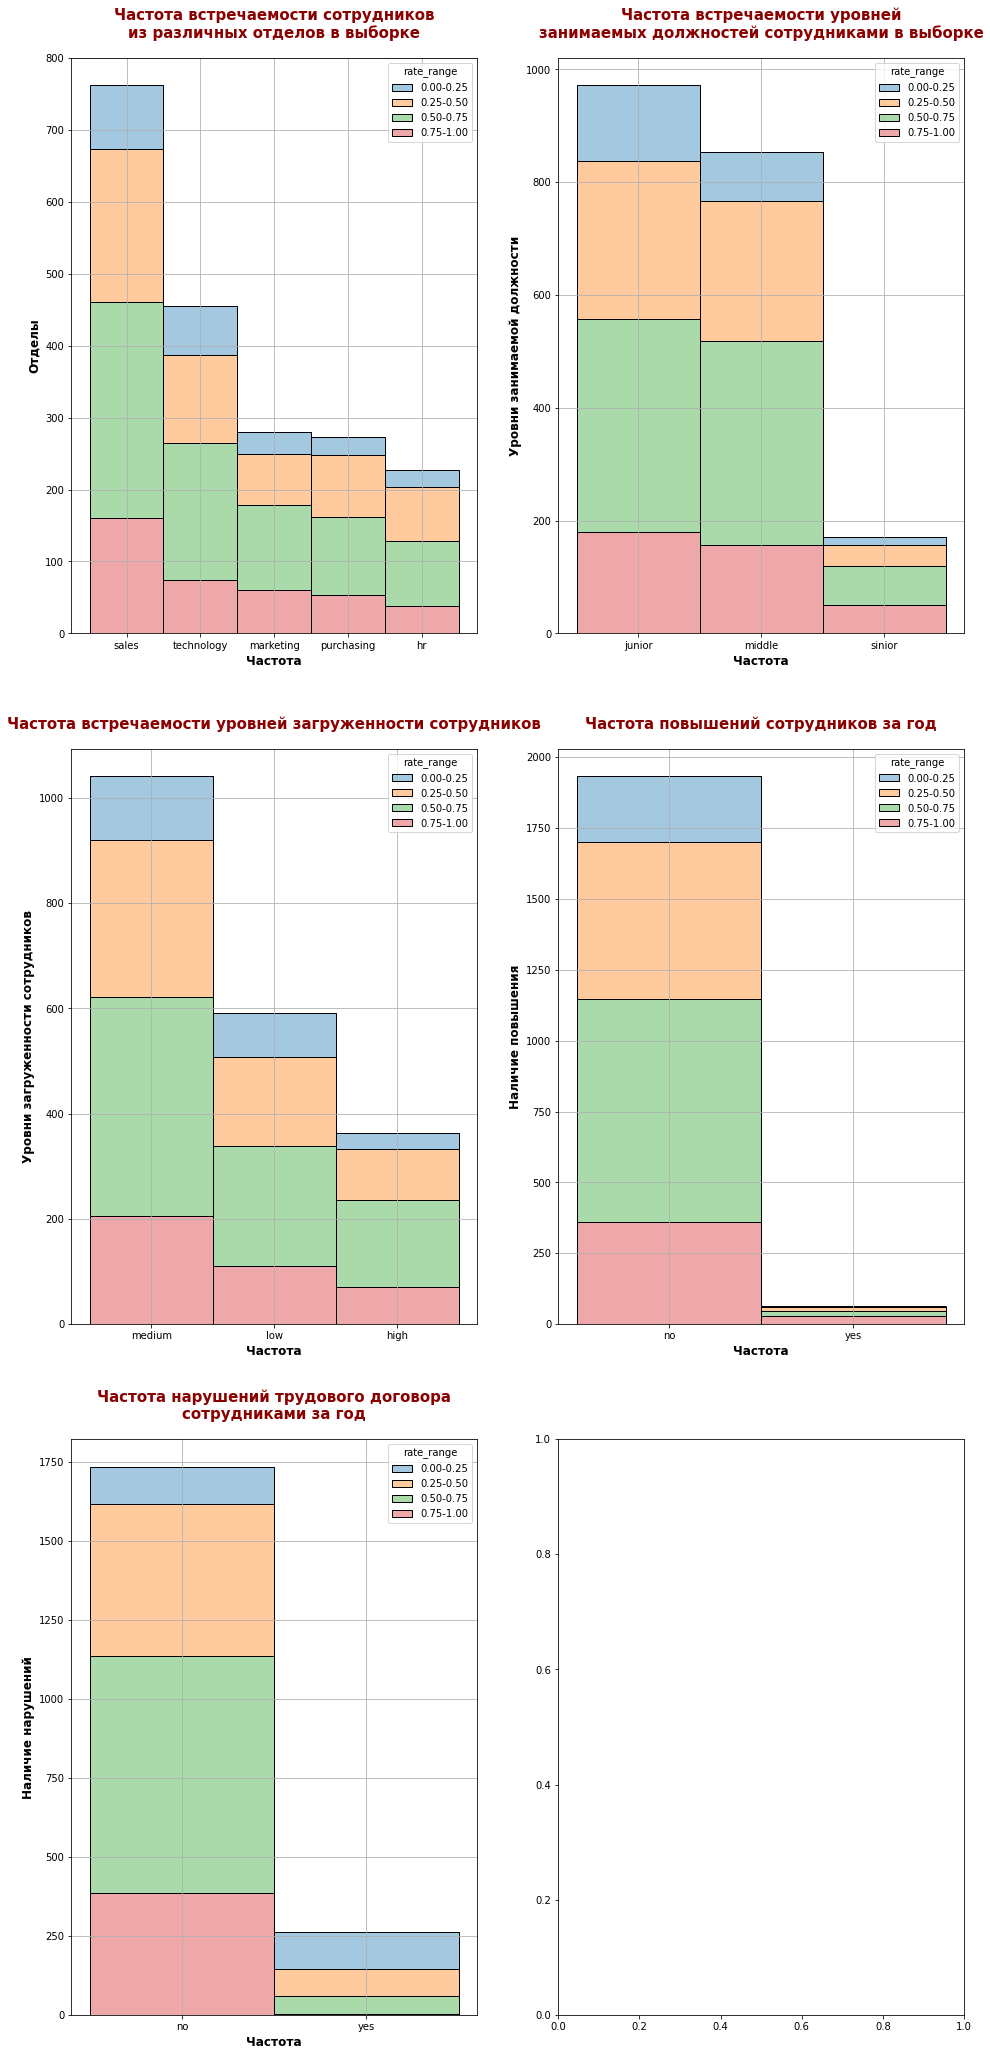

In [22]:
show_hists(df=analize_test_job_satisfaction_rate,
           columns=cat_params, 
           mask=cat_mask, 
           color_column='rate_range', 
           alpha=0.3, 
           cat=True, 
           in_row=2)

<hr>

Распределения качественных параметров также похожи на распределения из тренеровочной выборки.

<hr>

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>Распределения тренировочных и тестовых данных похожи.</p>

<p style='text-align: justify;'>Графики распределение длительности работы сотрудников в компании имеет форму распределения Пуассона.<br>Чем дольше работает сотрудник, тем выше вероятность, что он поставит высокую оценку, сотрудники, работающие в компании год и меньше, вероятнее всего не поставят оценку выше 0.75.</p>

<p style='text-align: justify;'>Распределения оценок качества работы сотрудников похожи на нормальное распределение со смещением вправо, в сторону повышенной оценки.<br>Обычно высокие оценки удовлетворенности - выше 0.5, ставят сотрудники, которых руководитель оценил на 4 и 5, такие сотрудники почти не ставят оценки меньше 0.25.</p>

<p style='text-align: justify;'>Зарплаты распределены нормально со смещением в лево, в сторону меньших значений. Есть небольшие выбросы со значениями от 70 до 100 тыс.<br>По графикам не прослеживается зависимость между зарплатой и тем, поставит сотрудник высокую, низкую или среднюю оценку.</p>

<p style='text-align: justify;'>Распределения оценок уровня удовлетворенности сотрудника в компании имеют нормальный вид.</p>
<br><br>
<p style='text-align: justify;'>Колличественные признаки имеют различные размерности, поэтому при подготовке данных будем их нормировать с помощью <b>StandardScaler</b>. Качественные параметры будем кодировать при помощи двух кодировщиков <b>OrdinalEncoder</b> и <b>OneHotEncoder</b>.</p>

<hr>

 <a id='corr_analysis'></a>

## Корреляционный анализ

In [23]:
def cor_heatmap(df: pd.DataFrame, parameters: list[str], 
                n_round: int=2, figsize: tuple[int] = (10, 10)) -> None:
    '''Heatmap of the correlation matrix (df[parameters])'''
    
    types = df.dtypes.reset_index()
    types.columns = ['index', 'type']
    quantitive = list(types.loc[(types['type'] == 'int64') | (types['type'] == 'float64'), 'index'])
    data_corr = df[parameters].phik_matrix(quantitive)
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(data_corr, dtype=bool))
    sns.heatmap(data_corr, 
                annot=True, 
                cmap='coolwarm',
                mask=mask,
                fmt=f".{n_round}f", 
                vmin=-1, 
                vmax=1, 
                center=0) 
    plt.title(f'Матрица корреляций, использующая метод Phik', 
                 weight='bold', 
                 size=15, 
                 color='darkred', 
                 pad=20)
    plt.show()

<hr>
<a id='mtrx'></a>
Построим матрицу корреляции и для качественных, и для количественных данных в <b>train_job_satisfaction_rate</b> для этого будем использовать метод Фи. 

<hr>

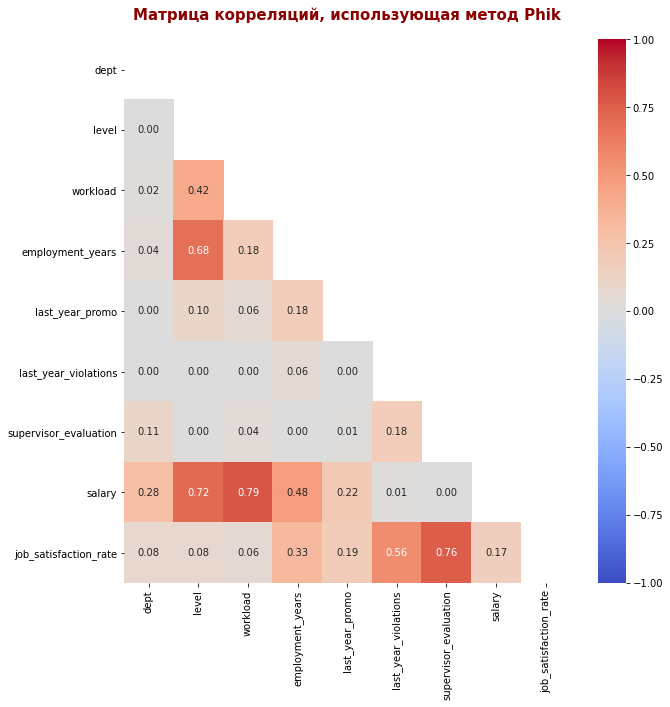

In [24]:
cor_heatmap(train_job_satisfaction_rate, 
            train_job_satisfaction_rate.columns.drop('id'))

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

По шкале Чеддока <b>слабую</b> корреляцию с целевым признаком имеют признаки:
 - Наличие повышения за последний год;
 - Зарплата;
 
<b>Умеренную</b> корреляционную связь с целевым признаком имеет:
 - Длительность работы в компании;
 
<b>Заметную</b>:
 - Наличие нарушений трудового договора за последний год;
 
<b>Высокую</b>:
 - Оценка качества работы сотрудника, которую дал руководитель;
 

<p style='text-align: justify;'>Значения коэффициентов корреляции не превышают 0.9, в данных не наблюдается мультиколлинеарность.</p>

<hr>

 <a id='section_5'></a>

## Подготовка данных

In [25]:
RANDOM_STATE = 1

In [26]:
train_job_satisfaction_rate = train_job_satisfaction_rate.reset_index(drop=True)

In [27]:
X_train = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

In [28]:
ohe_columns = ['dept', 
               'last_year_promo', 
               'last_year_violations']

ord_columns = ['level', 
               'workload']


num_columns = ['employment_years', 
               'supervisor_evaluation', 
               'salary']

In [29]:
ohe_pipe = Pipeline([('simpleImputer_ohe', 
                      SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
                     ('ohe', 
                      OneHotEncoder(drop='first', handle_unknown='error', sparse=False))])

ord_pipe = Pipeline([('simpleImputer_before_ord', 
                      SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ord', 
                      OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], 
                                                 ['low', 'medium', 'high']], 
                                     handle_unknown='use_encoded_value', unknown_value=np.nan)), 
                     ('simpleImputer_after_ord', 
                      SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])


data_preprocessor = ColumnTransformer([('ohe', ohe_pipe, ohe_columns), 
                                       ('ord', ord_pipe, ord_columns),
                                       ('num', StandardScaler(), num_columns)], 
                                      remainder='passthrough')

pipe_final = Pipeline([('preprocessor', data_preprocessor), 
                       ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))])

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'><br>Созданы пайплайны для кодирования категориальных признаков с помощью <b>OneHotEncoder</b> и <b>OrdinalEncoder</b>.
<br>Соберан процесс кодирования в объекте <b>ColumnTransformer</b>, в нем же масштабируются количественные признаки с помощью <b>StandardScaler</b>.
<br>Создан финальный пайплайн, в котором данные обрабатываются в препроцессоре, а потом передаются в модель.</p>

<hr>

 <a id='section_6'></a>

## Обучение моделей

<hr>

<p style='text-align: justify;'>Создадим список словарей, в которых будут указаны модели и соотвтетствующие для них гиперпараметры, изменяющиеся в некотором диапазоне.</p>

<hr>

In [30]:
param_distribution = [{
                          'models':[DecisionTreeRegressor(random_state=RANDOM_STATE)], 
                          'models__max_depth':range(5, 20), 
                          'models__min_samples_split':range(2, 15), 
                          'models__max_features':range(5, 20)
                      },
                      {
                          'models':[KNeighborsRegressor()], 
                          'models__n_neighbors':range(6, 30)
                      },
                      {
                          'models':[LinearRegression()]
                      },
                      {
                          'models':[SVR(kernel='poly')], 
                          'models__degree':range(2, 13)
                      }]

<hr>

<p style='text-align: justify;'>Определим собственную метрику <b>SMAPE</b> (симметричное среднее абсолютное процентное отклонение), расчитываемая по формуле:</p>

SMAPE = (100% / n) &sum;<sub>t=1</sub><sup>n</sup> (|y<sub>i</sub> - <span style="text-decoration: overline;">y</span><sub>i</sub>| / ((|<span style="text-decoration: overline;">y</span><sub>i</sub>| + |y<sub>i</sub>|) / 2))

 - <span style="text-decoration: overline;">y</span><sub>i</sub> - предсказанное значение целевого признака для объекта с порядковым номером i в выборке;
 - y<sub>i</sub> – фактическое значение целевого признака для объекта с порядковым номером i в выборке;
 - n – количество объектов в выборке.

<p style='text-align: justify;'>Далее с помощью инструмента <b>RandomizedSearchCV</b> обучим ранее определенные модели, в качестве метрики будем использовать <b>SMAPE</b>. Для лучшей модели посчитаем метрику на тестовых данных.</p>

<hr>

In [31]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    n = len(y_true)
    return 100 / n * sum(2 * abs(y_true[i] - y_pred[i]) / (abs(y_true[i]) + abs(y_pred[i])) for i in range(n))

In [32]:
scorer = make_scorer(smape, greater_is_better=False)

randomized_search = RandomizedSearchCV(pipe_final, 
                                       param_distribution, 
                                       cv=5,
                                       scoring=scorer,
                                       random_state=RANDOM_STATE,
                                       n_jobs=-1, 
                                       n_iter=50)

In [33]:
randomized_search.fit(X_train, y_train);

In [34]:
test_data = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')
test_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [35]:
X_test = test_data.reset_index(drop=True).drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_data.reset_index(drop=True)['job_satisfaction_rate']

In [36]:
model_name = str(type(randomized_search.best_estimator_.named_steps['models'])).split('.')[-1][:-2]

print(f"\033[92m\033[1mМодель {str(model_name).split('(')[0]}\033[0m".center(140))
print(f"Метрика SMAPE при валидации: {round(abs(randomized_search.best_score_), 2)}")
print(f"Метрика SMAPE на тестовых данных: {round(abs(scorer(randomized_search.best_estimator_, X_test, y_test)), 2)}")

                                                 Модель DecisionTreeRegressor                                                  
Метрика SMAPE при валидации: 14.52
Метрика SMAPE на тестовых данных: 13.53


<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В результате подбора и обучения моделей была получена лучшая модель <b>DecisionTreeRegressor</b> с метрикой <b>SMAPE = 13.53</b> на тестовой выборке.</p>

<hr>

 <a id='conclusion'></a>

## Промежуточные выводы

<hr>
В результате решения первой задачи были загружены и обработаны предоставленные данные. Проведен исследовательский и корреляционный анализы данных, исходя из которых выявлено: 

 - распределения тренировочных и тестовых данных похожи;
 - представленны различные виды данных: <i>количественные</i>, <i>качественные</i> и <i>ранговые</i>;
 - мультиколлинеарность в данных не наблюдается;

Данные были обработаны с использованием пайплайнов для кодирования категориальных признаков с помощью <b>OneHotEncoder</b> и <b>OrdinalEncoder</b>. Количественные данные были масштабированы с использованием <b>StandardScaler</b>..

<p style='text-align: justify;'>В результате подбора и обучения моделей была получена лучшая модель <b>DecisionTreeRegressor</b> с метрикой <b>SMAPE = 13.53</b> на тестовой выборке. Вероятнее всего лучшая метрика <b>SMAPE</b> у <b>DecisionTreeRegressor</b> обусловлена его способностью лучше улавливать сложные, нелинейные зависимости в данных, относительно линейных моделей.</p>

<hr>

<div align='center'><font size=4.5><b>Предсказание увольнения сотрудника из компании</b></font></div>

 <a id='download2'></a>

## Загрузка данных

In [37]:
file_names=['/datasets/train_quit.csv',
            '/datasets/test_target_quit.csv']
train_quit, test_target_quit = batch_opening(file_names)

In [38]:
file_names = ['train_quit.csv', 'test_features.csv', 'test_target_quit.csv']
frames = {'train_quit':train_quit, 
          'test_features':test_features, 
          'test_target_quit':test_target_quit}
for i, data in enumerate(frames.values(), 0):
    print()
    print(("\033[92mДАННЫЕ ИЗ ФАЙЛА \033[1m" + file_names[i]).center(140))
    display(data.head())
    display(data.info())


                                                  ДАННЫЕ ИЗ ФАЙЛА train_quit.csv                                                   


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None


                                                 ДАННЫЕ ИЗ ФАЙЛА test_features.csv                                                 


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None


                                               ДАННЫЕ ИЗ ФАЙЛА test_target_quit.csv                                                


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

В данном разделе были загружены данные из 2-х файлов в формате <i>.csv</i>. Тестовые данные будем использовать из текущего фрейма <b>test_features</b>, в котором уже выполнена предобрабоотка данных. Данные в файлах соответствуют описанию. Полученные фреймы:

 - <b>train_quit</b> содержит 4000 строк и 10 столбцов. Пропущенных занчений нет. Типы данных: <i><font color='purple'>int</font></i> и <i><font color='purple'>str</font></i>.
 - <b>test_features</b> - ранее обработанные данные.
 - <b>test_target_quit</b> содержит 2000 строк и 2 столбца. Пропущенных значений в фрейме нет. Типы данных: <i><font color='purple'>int</font></i> и <i><font color='purple'>str</font></i>.

<hr>

 <a id='treatment2'></a>

##  Предобработка данных

<hr>

Объединим фреймы с тестовыми признаками и таргетом.

<hr>

In [39]:
test_quit = test_features.merge(test_target_quit, on='id', how='left')
display(test_quit.head())
test_quit.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB


<hr>

Объединение прошло успешно. Теперь проверим, есть ли дубликаты.

<hr>

In [40]:
train_quit['id'].duplicated().sum()

0

In [41]:
test_quit['id'].duplicated().sum()

0

In [42]:
column_names = ['dept', 
                'level', 
                'workload', 
                'last_year_promo', 
                'last_year_violations', 
                'quit']

frames = {'train_quit':train_quit, 
          'test_quit':test_quit}

show_unique_values(frames, column_names, just_all_unique=False)


                                 Уникальные значения в фрейме train_quit для столбца:                                 
________________________________________________________________________________________________________________________
dept
['hr', 'marketing', 'purchasing', 'sales', 'technology']

level
['junior', 'middle', 'sinior']

workload
['high', 'low', 'medium']

last_year_promo
['no', 'yes']

last_year_violations
['no', 'yes']

quit
['no', 'yes']

________________________________________________________________________________________________________________________


                                 Уникальные значения в фрейме test_quit для столбца:                                  
________________________________________________________________________________________________________________________
dept
['hr', 'marketing', 'nan', 'purchasing', 'sales', 'technology']

level
['junior', 'middle', 'nan', 'sinior']

workload
['high', 'low', 'medium']

last_year_promo
['no'

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В результате предобработки данных, были объединены фреймы с тестовыми данными. Неявные дубликаты в фрейимах <b>train_quit</b> и <b>test_quit </b> - отсутствуют.</p>

<hr>

 <a id='analysis2'></a>

## Исследовательский анализ данных

In [43]:
def scatter_plot(df: pd.DataFrame, column: str, target: str, color_column: str=None,
                 alpha: float = 0.4, ax: plt.Axes=None, figsize: tuple[int]=(8, 8),
                 title: str = None, xlabel: str = None, ylabel: str = None) -> None:
    '''Creation scatter plots'''
    
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
        
    sorted_data = df.sort_values(target)
    sns.scatterplot(data=df,
                    x=sorted_data[target],
                    y=sorted_data[column], 
                    hue=color_column,
                    alpha=alpha, 
                    ax=ax)
    ax.set_title(title, 
                 size=15, 
                 weight='bold', 
                 pad=20, 
                 color='DarkRed')
    ax.set_xlabel(xlabel, 
                  size=12,
                  weight='bold')
    ax.set_ylabel(ylabel, 
                  size=12,
                  weight='bold')
    ax.grid()

<hr>

Построим графики распределения для фрейма <b>train_quit</b>.

<hr>

In [44]:
num_params = ['employment_years', 
              'supervisor_evaluation', 
              'salary']
cat_params = ['dept', 
              'level', 
              'workload', 
              'last_year_promo', 
              'last_year_violations', 
              'quit']

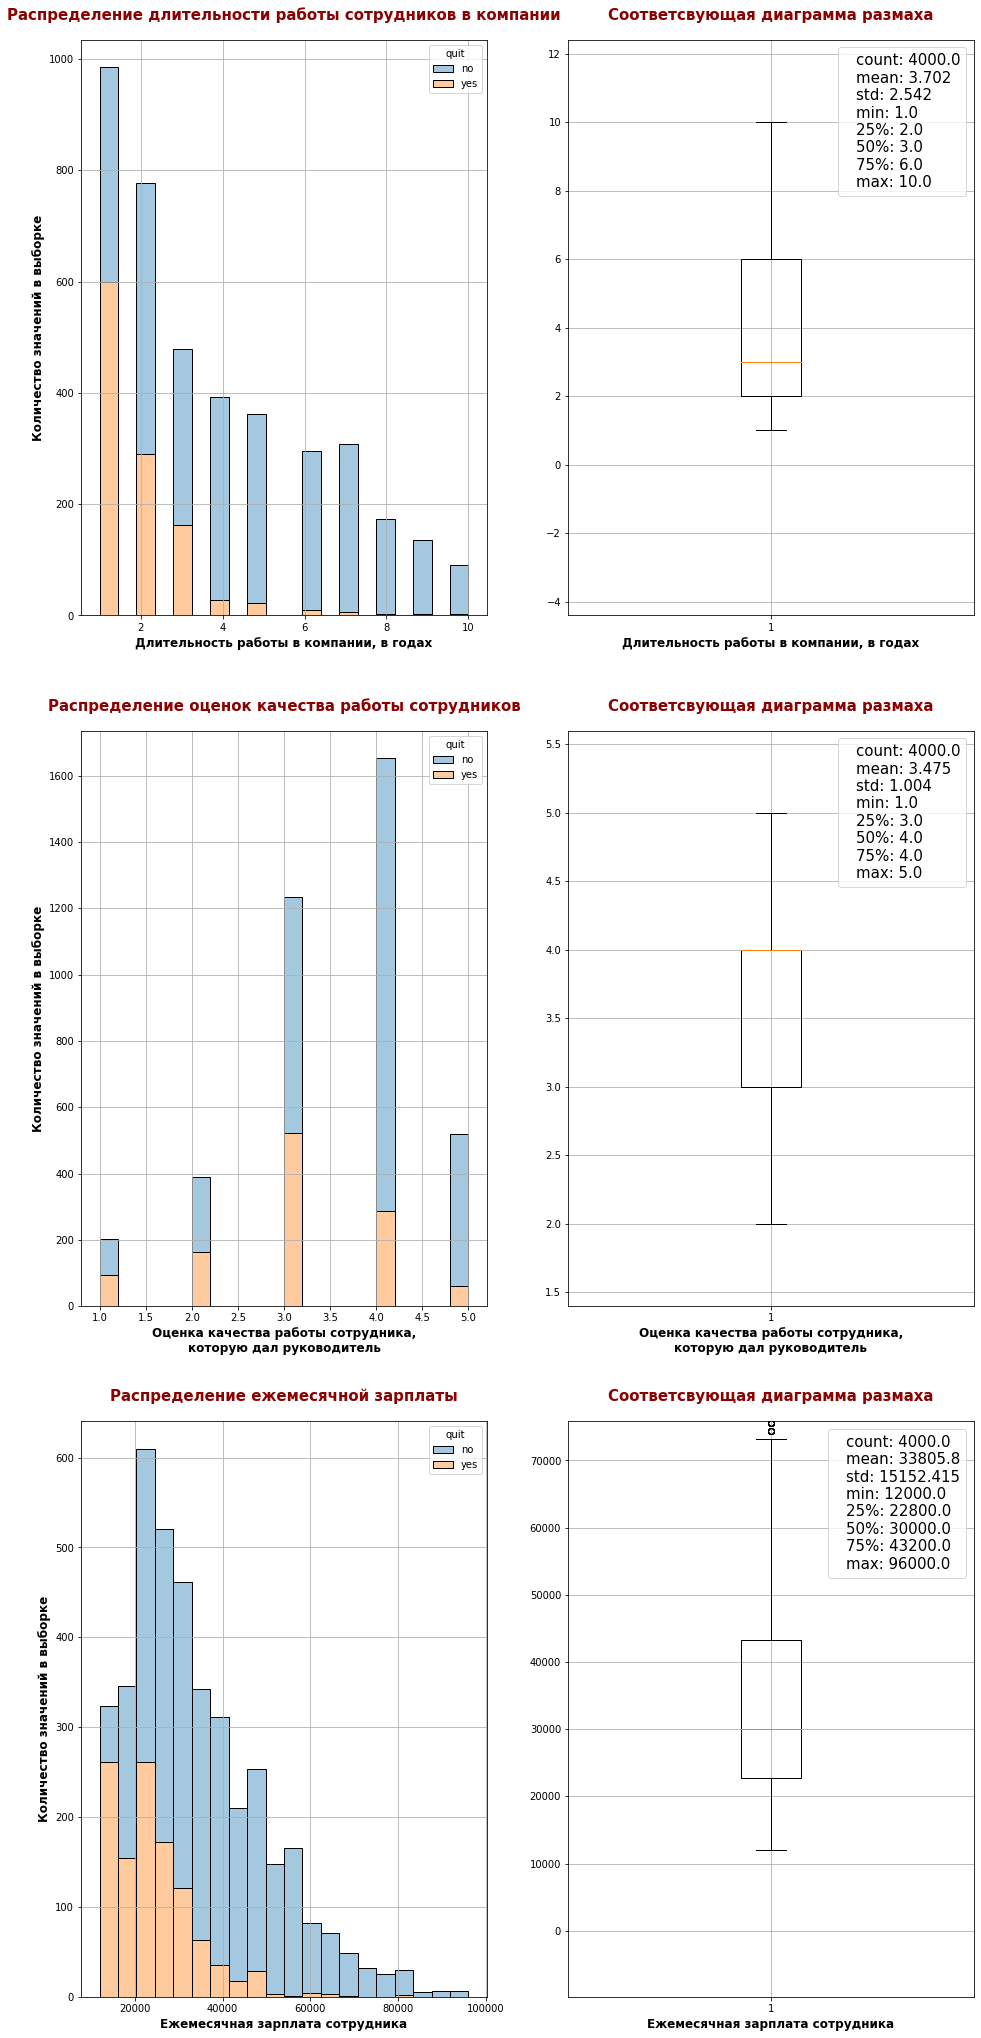

In [45]:
show_hists(df=train_quit,
           columns=num_params, 
           mask=num_mask, 
           bins=20, 
           color_column='quit', 
           alpha=0.3)

<hr>

Данные фрейма распределены аналлогично данным, используемым в первой задачи.

В основном из компании уходят сотрудники, проработавшие 3 года и меньше. Чаще увольняются сотрудники, качество работы которых было оценено руководителем на 3. Почти все уволившиеся сотрудники имели зарплату менее 50 тысяч.

<hr>

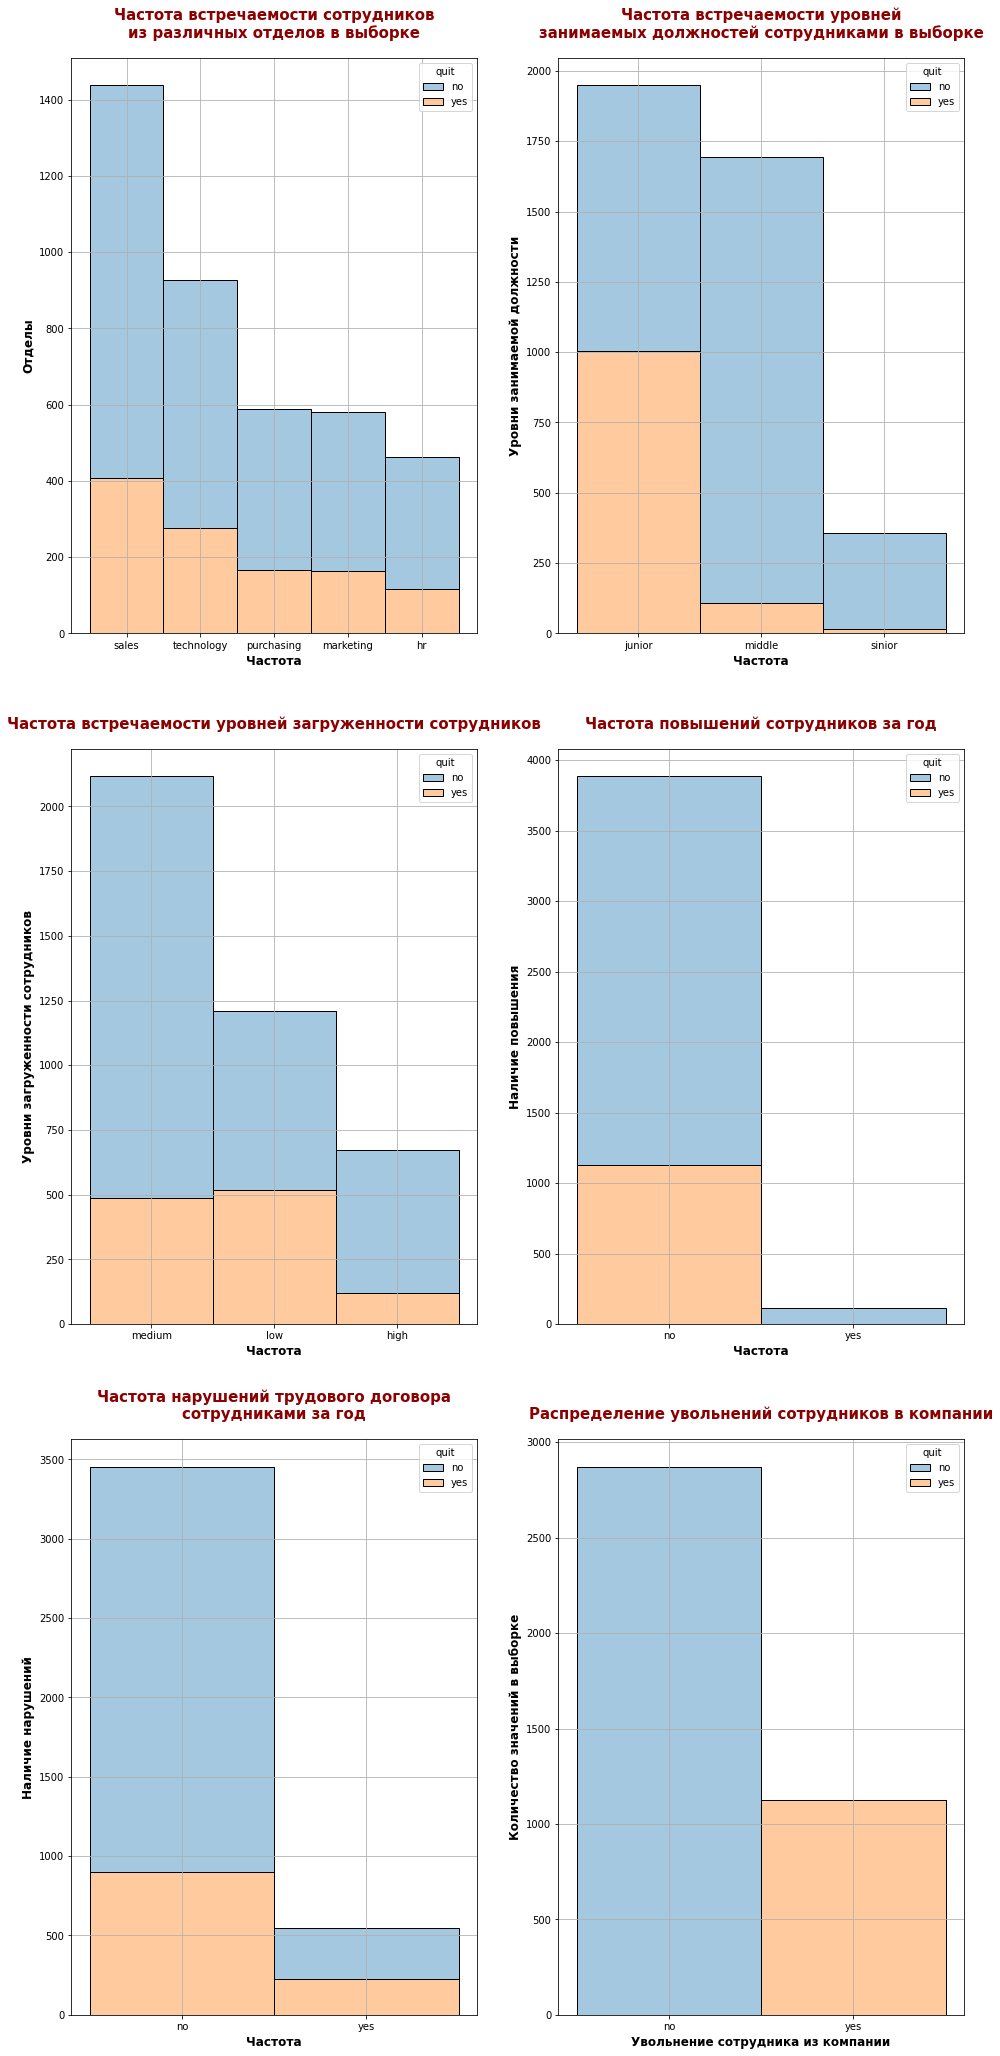

In [46]:
cat_mask['quit'] = ('Увольнение сотрудника из компании', 
                    'Количество значений в выборке', 
                    'Распределение увольнений сотрудников в компании')

show_hists(df=train_quit,
           columns=cat_params, 
           mask=cat_mask, 
           color_column='quit', 
           alpha=0.3, 
           cat=True, 
           in_row=2)

<hr>

В основном уволняющиеся сотрудники занимают младшие должности в отделе <i>'junior'</i>. Сотрудники, получившие повышение в течении последнего года, не увольняются (по выборке). Сотрудники, нарушившие трудовой договор за последний год, почти в половине случаев увольняются.

Построим графики распределения для фрейма <b>test_quit</b>.

<hr>

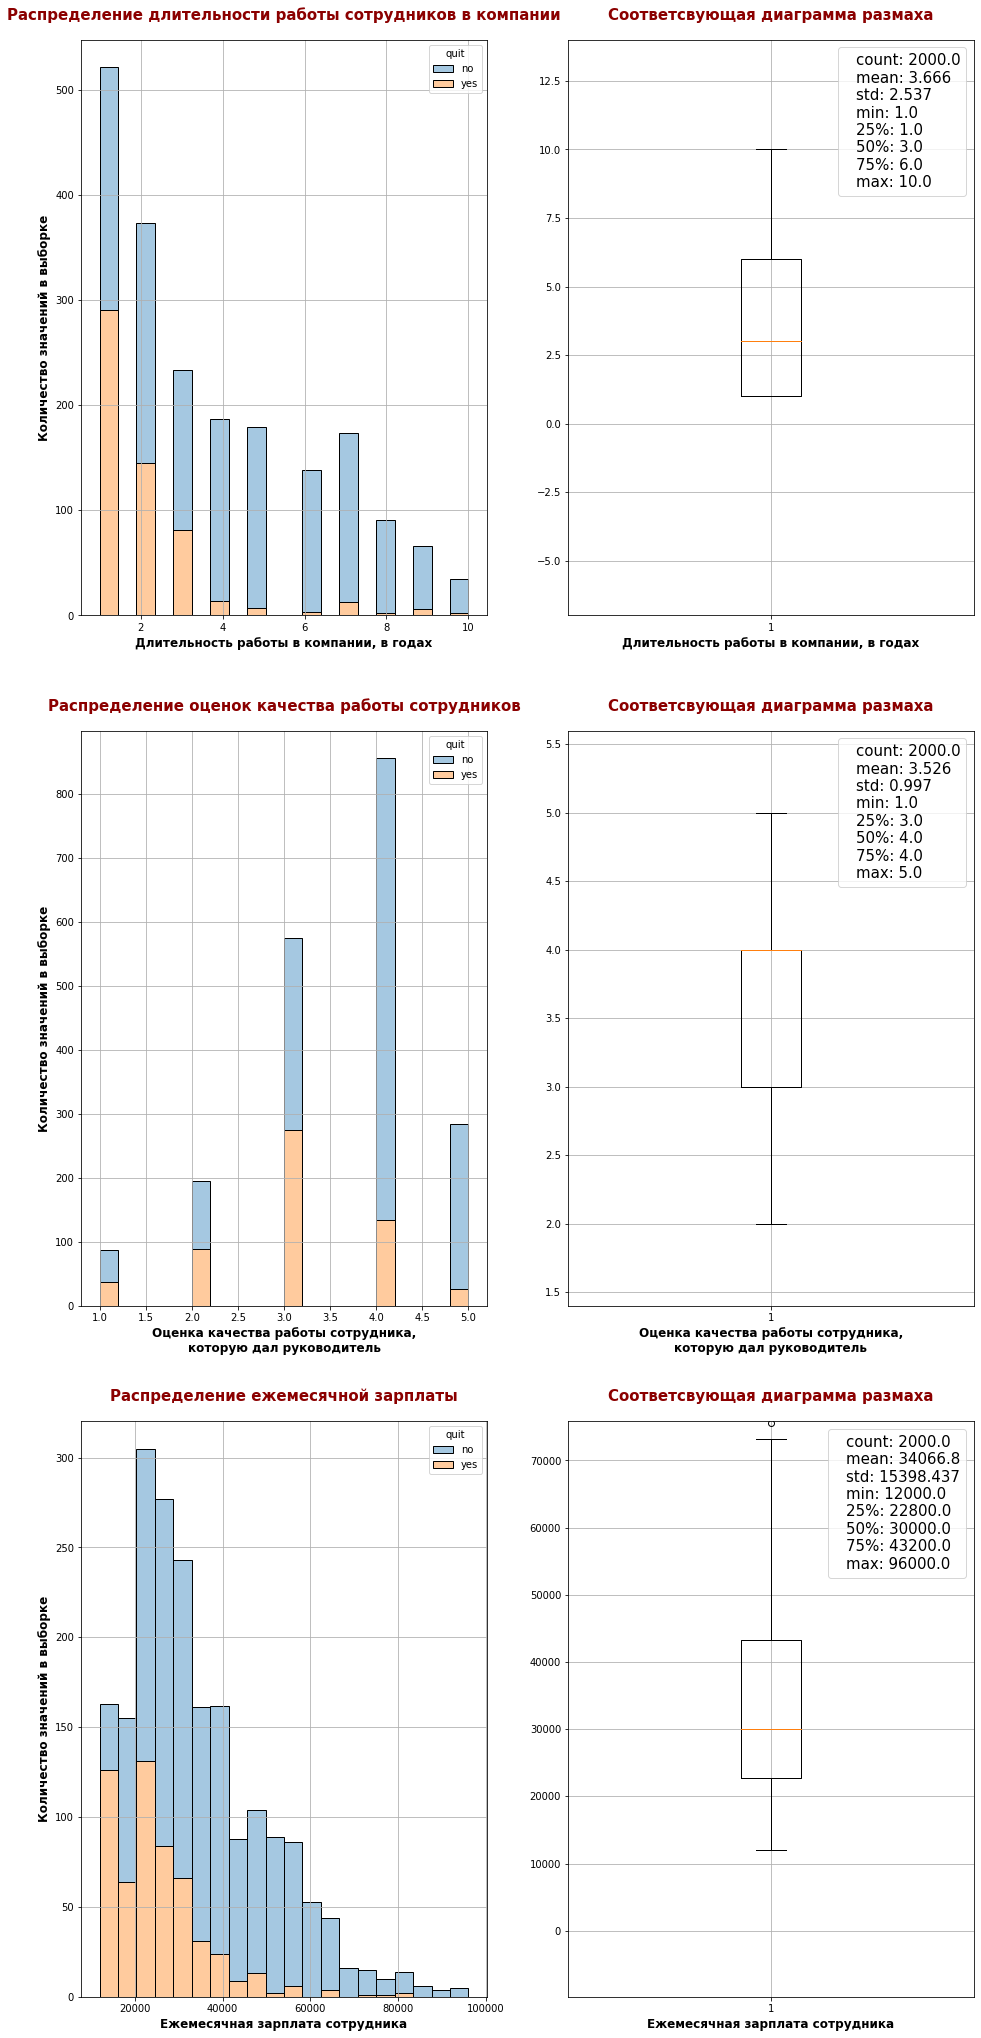

In [47]:
show_hists(df=test_quit,
           columns=num_params, 
           mask=num_mask, 
           bins=20, 
           color_column='quit', 
           alpha=0.3)

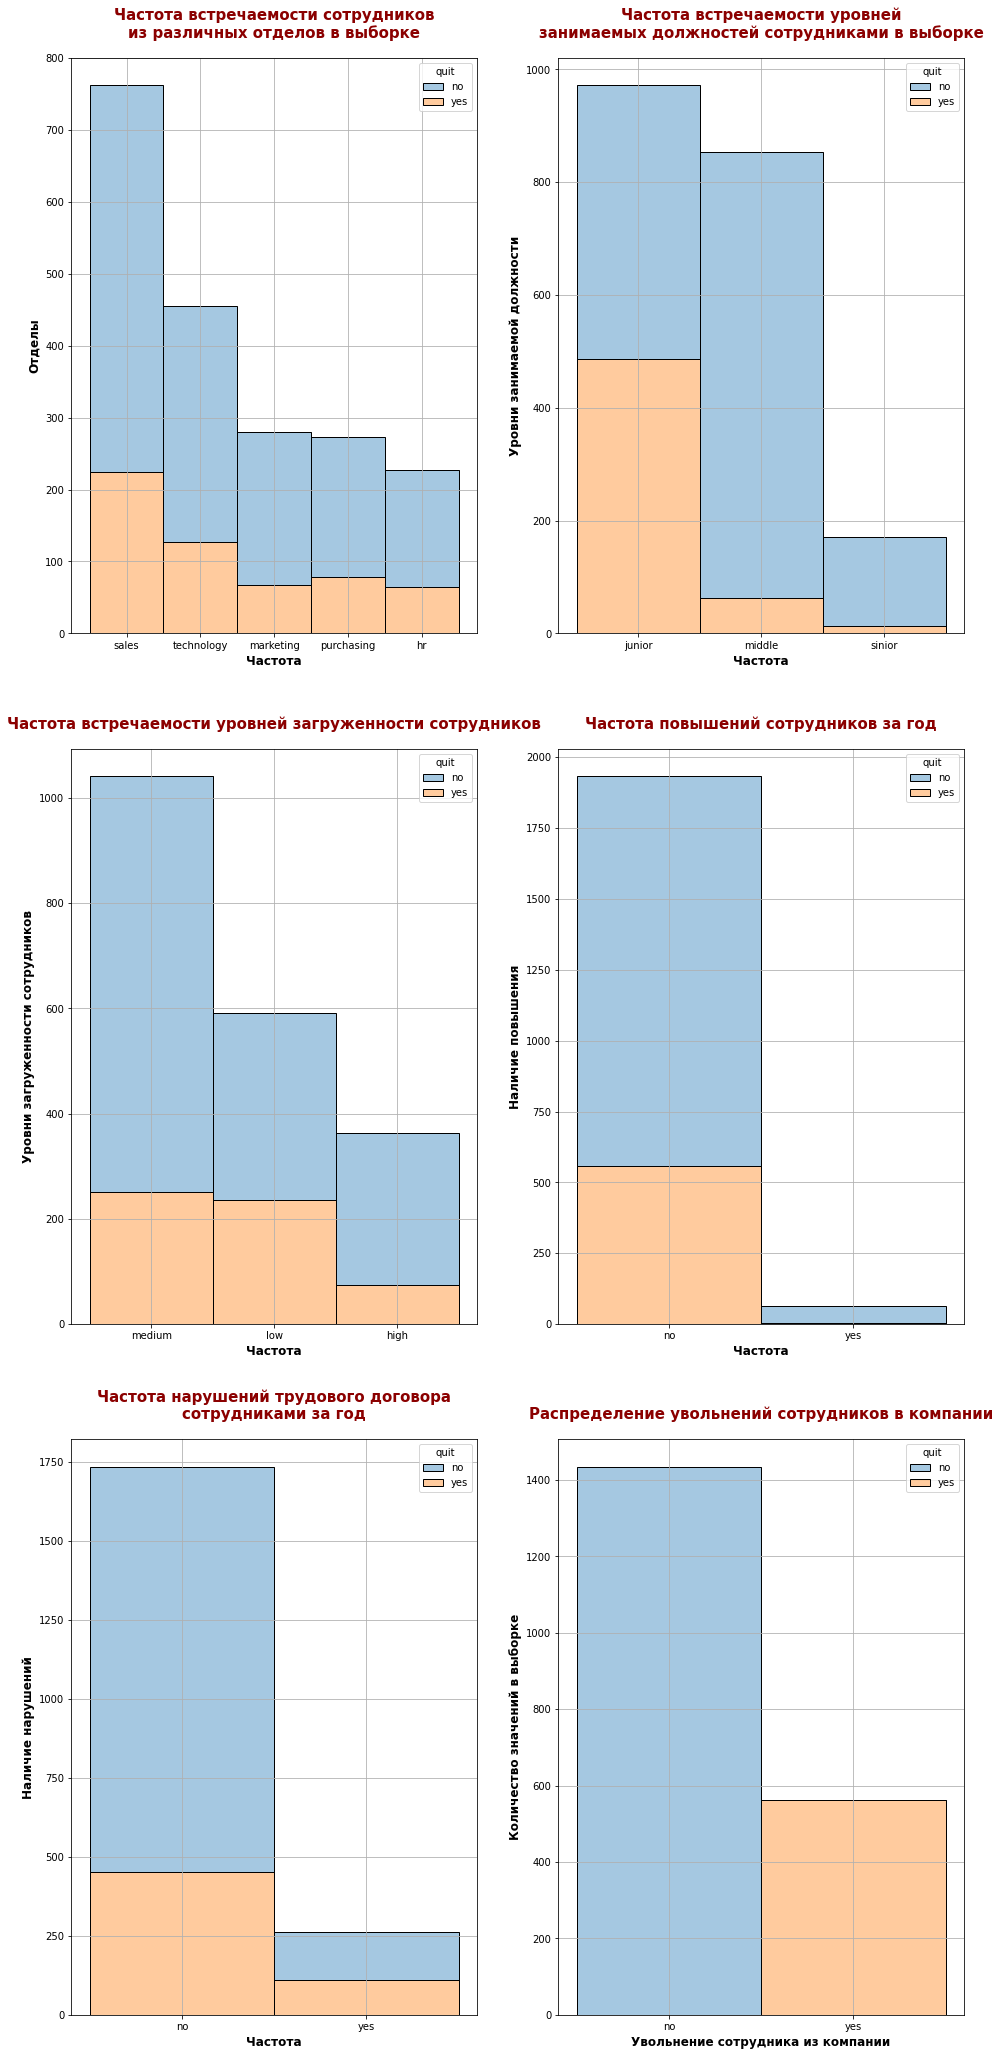

In [48]:
show_hists(df=test_quit.dropna(),
           columns=cat_params, 
           mask=cat_mask, 
           color_column='quit', 
           alpha=0.3, 
           cat=True, 
           in_row=2)

<hr>

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение.

<hr>

In [49]:
test_data['job_satisfaction_rate_predicted'] = randomized_search.best_estimator_.predict(X_test)
test_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,job_satisfaction_rate_predicted
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,0.883333
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,0.678750
2,467458,sales,middle,low,5,no,no,4,19200,0.64,0.657143
3,418655,sales,middle,low,6,no,no,4,19200,0.60,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,0.825556


In [50]:
full_test_data = test_data.merge(test_target_quit, on='id', how='left')
full_test_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,job_satisfaction_rate_predicted,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,0.883333,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,0.678750,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,0.657143,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,0.655000,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,0.825556,no


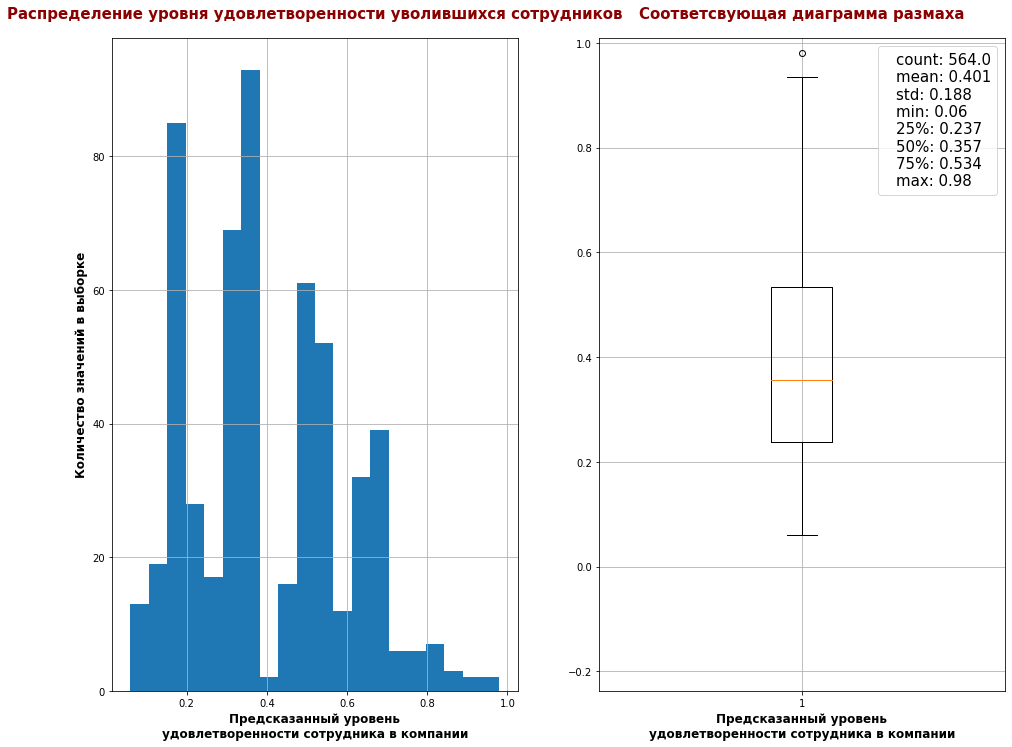

In [51]:
show_hists(df=full_test_data[full_test_data['quit'] == 'yes'],
           columns=['job_satisfaction_rate_predicted'], 
           mask={'job_satisfaction_rate_predicted':('Предсказанный уровень\nудовлетворенности сотрудника в компании', 
                                                    'Количество значений в выборке', 
                                                    'Распределение уровня удовлетворенности уволившихся сотрудников')}, 
           bins=20, 
           alpha=0.3)

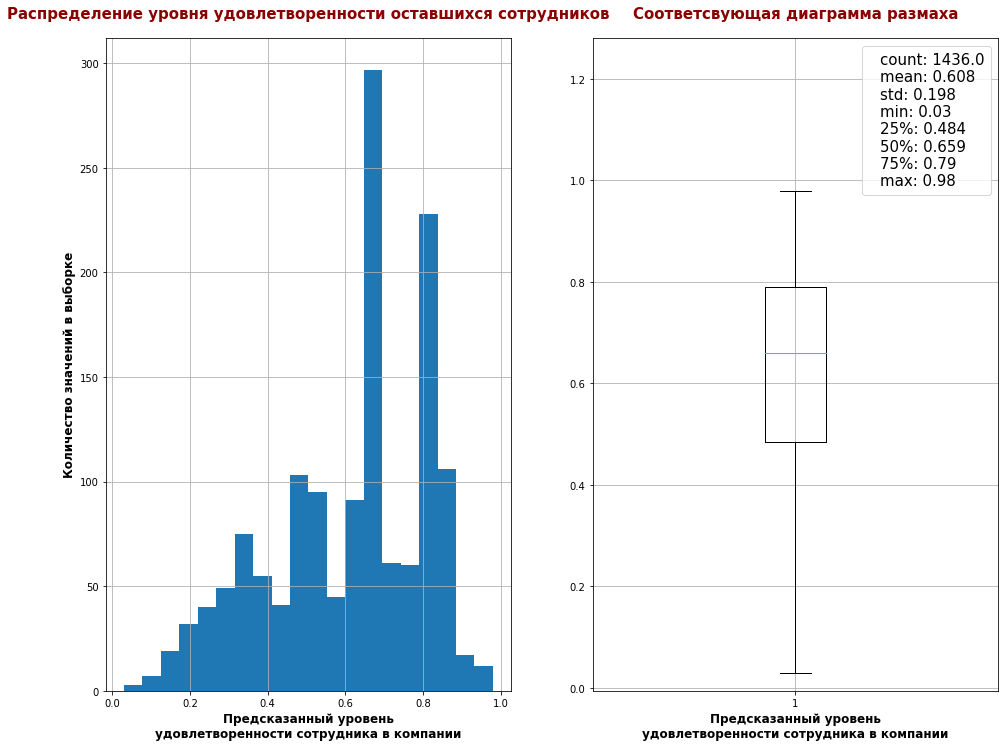

In [52]:
show_hists(df=full_test_data[full_test_data['quit'] == 'no'],
           columns=['job_satisfaction_rate_predicted'], 
           mask={'job_satisfaction_rate_predicted':('Предсказанный уровень\nудовлетворенности сотрудника в компании', 
                                                    'Количество значений в выборке', 
                                                    'Распределение уровня удовлетворенности оставшихся сотрудников')}, 
           bins=20, 
           alpha=0.3)

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

Распределения тренировочных и тестовых данных похожи.

Портрет увольняющегося сотрудника:
 - Работает в компании 3 года и менее;
 - Руководитель отдела оценивает качество работы сотрудника на 3;
 - Заработная плата сотрудника менее 50 тысяч;
 - Занимает младшую должность в отделе;
 - В течении последнего года у него не было повышений, и были нарушения трудового договора;

<p style='text-align: justify;'>Предположение аналитиков о том, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник, подтвердились. Распределения удовлетворенности сотрудников уволившихся и оставшихся имеют вид нормального распределения, но первыое смещено в сторону низких оценок, а последнее, наоборот, в сторону высоких.</p>

<hr>

 <a id='adding2'></a>

## Добавление нового входного признака

<hr>
Добавим предсказанные значения из первой задачи к данным <b>test_quit</b>
<hr>

In [53]:
train_quit['job_satisfaction_rate_predicted'] = randomized_search.best_estimator_.predict(train_quit.drop(['id', 'quit'], 
                                                                                                          axis=1))
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_predicted
0,723290,sales,middle,high,2,no,no,4,54000,no,0.650000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.826111
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [54]:
test_quit = test_quit.merge(test_data[['id', 'job_satisfaction_rate_predicted']], on='id', how='left')
test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_predicted
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.883333
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.678750
2,467458,sales,middle,low,5,no,no,4,19200,no,0.657143
3,418655,sales,middle,low,6,no,no,4,19200,no,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.825556


In [55]:
train_quit.shape

(4000, 11)

In [56]:
test_quit.shape

(2000, 11)

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>Данные <b>job_satisfaction_rate</b>, предсказанные лучшей моделью, успешно добавленны к тестовым данным <b>test_quit</b></p>

<hr>

 <a id='corr_analysis2'></a>

## Корреляционный анализ

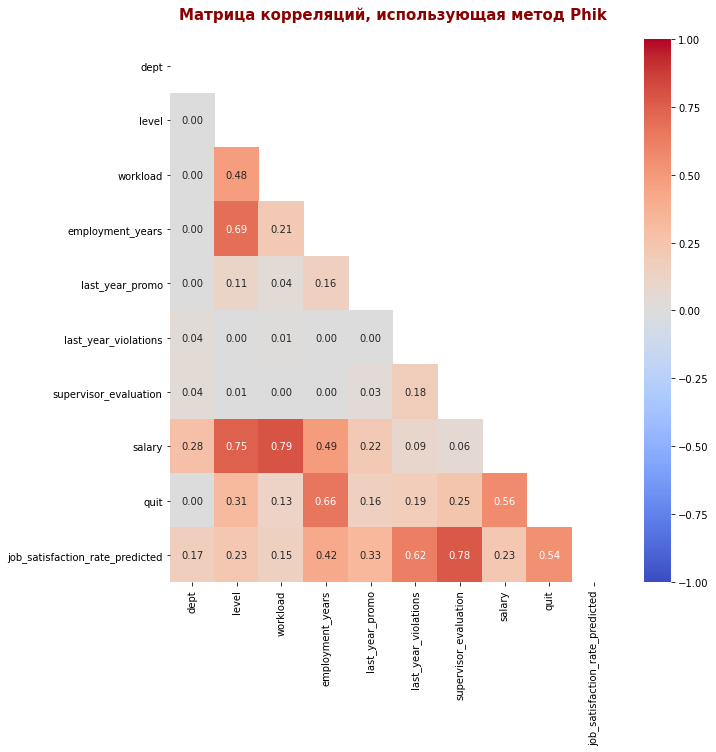

In [57]:
cor_heatmap(train_quit, 
            train_quit.columns.drop('id'))

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

По шкале Чеддока <b>слабую</b> корреляцию с целевым признаком <b>quit</b> имеют признаки:
 - Уровень загруженности сотрудника;
 - Наличие повышения за последний год;
 - Наличие нарушений трудового договора за последний год;
 - Оценка качества работы сотрудника, которую дал руководитель;
 
<b>Умеренную</b> корреляционную связь с целевым признаком имеет:
 - Уровень занимаемой должности;
 
<b>Заметную</b>:
 - Длительность работы в компании;
 - Уровень удовлетворённости сотрудника работой в компании;
 - Зарплата;


<p style='text-align: justify;'>Значения коэффициентов корреляции не превышают 0.9, в данных не наблюдается мультиколлинеарность.</p>

<hr>

 <a id='section_52'></a>

## Подготовка данных

In [58]:
train_quit = train_quit.reset_index(drop=True)
X_train = train_quit.drop(['id', 'quit'], axis=1)
y_train = train_quit['quit']

In [59]:
ohe_columns = ['dept', 
               'last_year_promo', 
               'last_year_violations']

ord_columns = ['level', 
               'workload']


num_columns = ['employment_years', 
               'supervisor_evaluation', 
               'salary', 
               'job_satisfaction_rate_predicted']

In [60]:
ohe_pipe = Pipeline([('simpleImputer_ohe', 
                      SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
                     ('ohe', 
                      OneHotEncoder(drop='first', handle_unknown='error', sparse=False))])

ord_pipe = Pipeline([('simpleImputer_before_ord', 
                      SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ord', 
                      OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], 
                                                 ['low', 'medium', 'high']], 
                                     handle_unknown='use_encoded_value', unknown_value=np.nan)), 
                     ('simpleImputer_after_ord', 
                      SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])


data_preprocessor = ColumnTransformer([('ohe', ohe_pipe, ohe_columns), 
                                       ('ord', ord_pipe, ord_columns),
                                       ('num', StandardScaler(), num_columns)], 
                                      remainder='passthrough')

pipe_final = Pipeline([('preprocessor', data_preprocessor), 
                       ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))])

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'><br>Созданы пайплайны для кодирования категориальных признаков с помощью <b>OneHotEncoder</b> и <b>OrdinalEncoder</b>.
<br>Соберан процесс кодирования в объекте <b>ColumnTransformer</b>, в нем же масштабируются количественные признаки с помощью <b>StandardScaler</b>.
<br>Создан финальный пайплайн, в котором данные обрабатываются в препроцессоре, а потом передаются в модель.</p>

<hr>

 <a id='section_62'></a>

## Обучение моделей

In [61]:
param_distribution = [{
                          'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)], 
                          'models__max_depth':range(5, 20), 
                          'models__min_samples_split':range(2, 15), 
                          'models__max_features':range(5, 20)
                      },
                      {
                          'models':[KNeighborsClassifier()], 
                          'models__n_neighbors':range(6, 30)
                      },
                      {
                          'models':[LogisticRegression(random_state=RANDOM_STATE, 
                                                       solver='saga', 
                                                       penalty='l1')], 
                          'models__C':range(1, 8)
                      },
                      {
                          'models':[SVC(random_state=RANDOM_STATE, 
                                        kernel='poly', 
                                        probability=True)], 
                          'models__degree':range(2, 13)
                      }]

In [62]:
randomized_search_quit = RandomizedSearchCV(pipe_final, 
                                            param_distribution, 
                                            cv=5,
                                            scoring='roc_auc',
                                            random_state=RANDOM_STATE,
                                            n_jobs=-1, 
                                            n_iter=50)

In [63]:
randomized_search_quit.fit(X_train, y_train);

In [64]:
X_test = test_quit.reset_index(drop=True).drop(['id', 'quit'], axis=1)
y_test = test_quit.reset_index(drop=True)['quit']

In [65]:
best_model = randomized_search_quit.best_estimator_
test_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

model_name = str(type(randomized_search_quit.best_estimator_.named_steps['models'])).split('.')[-1][:-2]

print(f"\033[92m\033[1mМодель {str(model_name).split('(')[0]}\033[0m".center(140))
print(f"Метрика ROC-AUC при валидации: {round(abs(randomized_search_quit.best_score_), 2)}")
print(f"Метрика ROC-AUC на тестовых данных: {round(test_score, 2)}")

                                                 Модель DecisionTreeClassifier                                                 
Метрика ROC-AUC при валидации: 0.93
Метрика ROC-AUC на тестовых данных: 0.92


<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В результате подбора и обучения моделей была получена лучшая модель <b>DecisionTreeRegressor</b> с метрикой <b>ROC_AUC = 0.92</b> на тестовой выборке.</p>


<hr>

 <a id='conclusion2'></a>

## Промежуточные выводы

<hr>

В результате решения первой задачи были загружены и обработаны предоставленные данные. Проведен исследовательский и корреляционный анализы данных, исходя из которых выявлено: 

 - распределения тренировочных и тестовых данных похожи;
 - мультиколлинеарность в данных не наблюдается;

Предположение аналитиков о том, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник, подтвердились. Распределения удовлетворенности сотрудников уволившихся и оставшихся имеют вид нормального распределения, но первое смещено в сторону низких оценок, а последнее, наоборот, в сторону высоких.

Составлен портрет увольняющегося сотрудника:
 - Работает в компании 3 года и менее;
 - Руководитель отдела оценивает качество работы сотрудника на 3;
 - Заработная плата сотрудника менее 50 тысяч;
 - Занимает младшую должность в отделе;
 - В течении последнего года у него не было повышений, и были нарушения трудового договора;

Данные были обработаны с использованием пайплайнов для кодирования категориальных признаков с помощью <b>OneHotEncoder</b> и <b>OrdinalEncoder</b>. Количественные данные были масштабированы с использованием <b>StandardScaler</b>..

<p style='text-align: justify;'>В результате подбора и обучения моделей была получена лучшая модель <b>DecisionTreeClassifier</b> с метрикой <b>ROC_AUC = 0.92</b> на тестовой выборке. <b>DecisionTreeClassifier</b> может показать лучшую метрику благодаря своей гибкости и способности захватывать сложные, нелинейные зависимости в данных</p>

<hr>

 <a id='conclusionfinal'></a>

## Итоговый вывод

<hr>

<p style='text-align: justify;'>В данной работе проводен анализ данных для оптимизации управления персоналом компании <b>«Работа с заботой»</b> с помощью машинного обучения для предсказания уровня удовлетворённости сотрудников и вероятности их увольнения. В ходе работы было решено две задачи:</p>

<b>1. Предсказание уровня удовлетворённости сотрудника.</b>

<p style='text-align: justify;'>В рамках задачи использовались данные о сотрудниках компании <b>«Работа с заботой»</b>, содержащие информацию о:</p>

 - отделе, в котором работает сотрудник;
 - уровене занимаемой должности;
 - уровене загруженности сотрудника;
 - длительности работы в компании (в годах);
 - повышениях за последний год;
 - нарушениях сотрудником трудового договора за последний год;
 - оценке качества работы сотрудника, которую дал руководитель;
 - ежемесячной зарплате сотрудника;
 - уровене удовлетворённости сотрудника работой в компании, целевой признак.
 
<p style='text-align: justify;'>Изначально данные были разбиты на тренировочные и тестовые. Тестовые данные в свою очередь, были разбиты на фреймы с входными признаками и целевым признаком. После загрузки данных, в них были выявлены пропущенные значения.</p>

<p style='text-align: justify;'>В процессе предобработки данных, были обнаруженны пустые значения ' ' в некоторых столбцах, они были заменены на значения None и обработаны в пайплайне.</p>

Были проведены исследовательский и корреляционный анализы. Для всех признаков построены распределения, отражающие различия по целевому признаку. По итогам исследовательского анализа были сделаны следующие выводы:
 - Чем дольше работает сотрудник, тем выше вероятность, что он поставит высокую оценку, сотрудники, работающие в компании год и меньше, вероятнее всего не поставят оценку выше 0.75.
 - Обычно высокие оценки удовлетворенности - выше 0.5, ставят сотрудники, которых руководитель оценил на 4 и 5, такие сотрудники почти не ставят оценки меньше 0.25.
 - По графикам не прослеживается зависимость между зарплатой и тем, поставит сотрудник высокую, низкую или среднюю оценку.
 
В ходе  корреляционного анализа, мультиколлинеарность не была выявлена.

<p style='text-align: justify;'>При подготовке данных, были использованы пайплайны для кодирования категориальных признаков с помощью OneHotEncoder и OrdinalEncoder. Количественные данные были масштабированы с использованием StandardScaler.</p>

<p style='text-align: justify;'>В процессе обучения были выбраны модели <b>DecisionTreeRegressor</b>, <b>KNeighborsRegressor</b>, <b>LinearRegression</b> и <b>SVR</b> с различными гиперпараметрами. Обучение производилось с использованием инструмента <b>RandomizedSearchCV</b>. В качестве метрики качества модели была выбрана <b>SMAPE</b> - симметричное среднее абсолютное процентное отклонение.</p>

Лучшей моделью, с результатом <b>SMAPE = 13.53</b> на тестовой выборке, стала модель <b>DecisionTreeRegressor</b>.
<br><br><br>
<b>2. Ппредсказание увольнения сотрудника из компании.</b>

<p style='text-align: justify;'>В рамках этой задачи использовались аналогичные данные, в качестве целевого признака был параметр указывающий, уволился ли сотрудник или нет.</p>

<p style='text-align: justify;'>В ходе предобработки данных, были объединены фреймы с тестовыми данными. Пропуски были обработаны в пайплайне.</p>

<p style='text-align: justify;'>Исследовательский анализ покакзал, что данные распределены аналогичным образом, что и впервой задаче.</p>

Составлен портрет увольняющегося сотрудника:
 - Работает в компании 3 года и менее;
 - Руководитель отдела оценивает качество работы сотрудника на 3;
 - Заработная плата сотрудника менее 50 тысяч;
 - Занимает младшую должность в отделе;
 - В течении последнего года у него не было повышений, и были нарушения трудового договора;
 
<p style='text-align: justify;'>Проверено предположение аналитиков о том, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник, оно подтвердилось. Распределения удовлетворенности сотрудников уволившихся и оставшихся имеют вид нормального распределения, но первое смещено в сторону низких оценок, а последнее, наоборот, в сторону высоких.</p>

<p style='text-align: justify;'>К тестовым и тренеровочным данным добавлен признак удовлетворённости сотрудника работой в компании, предсказанный ранее обученной моделью.</p>

<p style='text-align: justify;'>Корреляционный анализ также не показал наличие мультиколлинеарности в признаках.</p>

Данные были подготовленны таким же образом, что и в первой задаче.

<p style='text-align: justify;'>В процессе обучения были выбраны модели <b>DecisionTreeClassifier</b>, <b>KNeighborsClassifier</b>, <b>LogisticRegression</b> и <b>SVC</b> с различными гиперпараметрами. Обучение производилось с использованием инструмента <b>RandomizedSearchCV</b>. В качестве метрики качества модели была выбрана <b>ROC_AUC</b>.</p>

Лучшей моделью, с результатом <b>ROC_AUC = 0.92</b> на тестовой выборке, стала модель <b>DecisionTreeRegressor</b>.